In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(38, 79061)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Gaps' in col and '18k' in col]

['Mean N gaps in g at 24hr in top 18k Gaps_24hr g band HealpixSlicer',
 'Mean N gaps in g at 3hr in top 18k Gaps_3hr g band HealpixSlicer',
 'Mean N gaps in g at 7hr in top 18k Gaps_7hr g band HealpixSlicer',
 'Mean N gaps in i at 24hr in top 18k Gaps_24hr i band HealpixSlicer',
 'Mean N gaps in i at 3hr in top 18k Gaps_3hr i band HealpixSlicer',
 'Mean N gaps in i at 7hr in top 18k Gaps_7hr i band HealpixSlicer',
 'Mean N gaps in r at 24hr in top 18k Gaps_24hr r band HealpixSlicer',
 'Mean N gaps in r at 3hr in top 18k Gaps_3hr r band HealpixSlicer',
 'Mean N gaps in r at 7hr in top 18k Gaps_7hr r band HealpixSlicer',
 'Mean N gaps in u at 24hr in top 18k Gaps_24hr u band HealpixSlicer',
 'Mean N gaps in u at 3hr in top 18k Gaps_3hr u band HealpixSlicer',
 'Mean N gaps in u at 7hr in top 18k Gaps_7hr u band HealpixSlicer',
 'Mean N gaps in y at 24hr in top 18k Gaps_24hr y band HealpixSlicer',
 'Mean N gaps in y at 3hr in top 18k Gaps_3hr y band HealpixSlicer',
 'Mean N gaps in y at 7h

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
             'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'FF u': '',
         'FF g': '',
         'FF r': '',
         'FF i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
#data['KNe single model'] # data['KNe ZTF simple']

In [7]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [8]:
mag_data

g          i          r          u  \
baseline_v2.0_10yrs             26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs             26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs             26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs             26.688123  26.264600  26.818287  25.668262   
baseline_v3.2_10yrs             26.678103  26.295888  26.807880  25.622696   
ddf_loaded_uy_fl01_v3.2_10yrs   26.708670  26.309774  26.827770  25.634860   
ddf_loaded_uy_fl02_v3.2_10yrs   26.700077  26.301893  26.820188  25.634760   
ddf_loaded_uy_fl04_v3.2_10yrs   26.687919  26.295733  26.814110  25.630836   
ddf_loaded_uy_fl08_v3.2_10yrs   26.689764  26.290325  26.804781  25.614432   
ddf_loaded_uy_fl15_v3.2_10yrs   26.683190  26.293622  26.807767  25.616513   
ddf_loaded_uzy_fl01_v3.2_10yrs  26.698661  26.306137  26.829297  25.644679   
ddf_loaded_uzy_fl02_v3.2_10yrs  26.700805  26.303820  26.821920  25.635951   
ddf_loaded_uzy_fl04_v3.2_10yrs  26.686736  26.294044  26.815071  25.623757   
ddf_loaded_uzy_fl08_v3.2_10yrs  26.681853  26.289457  26.815842  25.621753   
ddf_loaded_uzy_fl15_v3.2_10yrs  26.682505  26.284326  26.804415  25.614982   
filter_uy_v3.2_10yrs            26.678103  26.295888  26.807880  25.622696   
filter_uz_v3.2_10yrs            26.692228  26.284042  26.825435  25.622543   
filter_uzy_v3.2_10yrs           26.691120  26.283071  26.811163  25.621942   
more_long_v3.2_10yrs            26.616609  26.249805  26.768763  25.590579   
no_long_v3.2_10yrs              26.713987  26.294080  26.824890  25.616507   
noroll_v3.2_10yrs               26.723908  26.300915  26.833570  25.647676   
retro_baseline_v2.0_10yrs       26.835006  26.308518  26.850968  25.707301   
weather_cloudso0v3.2_10yrs      26.678103  26.295888  26.807880  25.622696   
weather_cloudso10v3.2_10yrs     26.698955  26.310455  26.829829  25.615035   
weather_cloudso12v3.2_10yrs     26.710434  26.308694  26.829664  25.605524   
weather_cloudso14v3.2_10yrs     26.696307  26.311099  26.834174  25.628712   
weather_cloudso16v3.2_10yrs     26.708793  26.312623  26.833674  25.619873   
weather_cloudso18v3.2_10yrs     26.711683  26.312283  26.829771  25.616267   
weather_cloudso1v3.2_10yrs      26.711959  26.306222  26.833853  25.645135   
weather_cloudso20v3.2_10yrs     26.698599  26.302370  26.821137  25.611280   
weather_cloudso2v3.2_10yrs      26.715492  26.310439  26.836556  25.649037   
weather_cloudso30v3.2_10yrs     26.673798  26.294885  26.814374  25.586194   
weather_cloudso31v3.2_10yrs     26.687292  26.311861  26.820321  25.593831   
weather_cloudso35v3.2_10yrs     26.690478  26.301940  26.820419  25.601691   
weather_cloudso36v3.2_10yrs     26.702632  26.305427  26.822619  25.612287   
weather_cloudso4v3.2_10yrs      26.727492  26.327064  26.847992  25.652457   
weather_cloudso6v3.2_10yrs      26.738654  26.331259  26.850661  25.661720   
weather_cloudso8v3.2_10yrs      26.702936  26.311819  26.827798  25.630971   

                                        y          z  
baseline_v2.0_10yrs             24.762720  25.510379  
baseline_v2.1_10yrs             24.728145  25.486640  
baseline_v2.2_10yrs             24.782743  25.581317  
baseline_v3.0_10yrs             24.756955  25.524781  
baseline_v3.2_10yrs             24.766647  25.586860  
ddf_loaded_uy_fl01_v3.2_10yrs   24.778280  25.595670  
ddf_loaded_uy_fl02_v3.2_10yrs   24.779933  25.596102  
ddf_loaded_uy_fl04_v3.2_10yrs   24.775981  25.588580  
ddf_loaded_uy_fl08_v3.2_10yrs   24.768987  25.583518  
ddf_loaded_uy_fl15_v3.2_10yrs   24.762147  25.575013  
ddf_loaded_uzy_fl01_v3.2_10yrs  24.795440  25.592514  
ddf_loaded_uzy_fl02_v3.2_10yrs  24.782476  25.583235  
ddf_loaded_uzy_fl04_v3.2_10yrs  24.781748  25.579778  
ddf_loaded_uzy_fl08_v3.2_10yrs  24.770003  25.574889  
ddf_loaded_uzy_fl15_v3.2_10yrs  24.768926  25.569402  
filter_uy_v3.2_10yrs            24.766647  25.586860  
filter_uz_v3.2_10yrs            24.781018  25.562303  
filter_

In [9]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS   N SN ECDFS    N SN EDFS  \
baseline_v2.0_10yrs              638.253284   586.826209   974.231557   
baseline_v2.1_10yrs              548.479625   545.669910   875.981802   
baseline_v2.2_10yrs              708.239238   685.202422  1067.553931   
baseline_v3.0_10yrs              955.159293   799.584601  1266.961769   
baseline_v3.2_10yrs              971.481238   868.593513  1528.851192   
ddf_loaded_uy_fl01_v3.2_10yrs    857.379633   706.813786  1268.470459   
ddf_loaded_uy_fl02_v3.2_10yrs    992.720699   914.078093  1523.082694   
ddf_loaded_uy_fl04_v3.2_10yrs   1077.527601  1047.846424  1631.013584   
ddf_loaded_uy_fl08_v3.2_10yrs   1163.416261  1113.221455  1692.126968   
ddf_loaded_uy_fl15_v3.2_10yrs   1201.092034  1167.865557  1761.117457   
ddf_loaded_uzy_fl01_v3.2_10yrs   859.471823   734.550770  1232.464265   
ddf_loaded_uzy_fl02_v3.2_10yrs   980.423642   936.398009  1478.748433   
ddf_loaded_uzy_fl04_v3.2_10yrs  1104.006281  1059.583509  1683.163078   
ddf_loaded_uzy_fl08_v3.2_10yrs  1163.600118  1130.550249  1735.787310   
ddf_loaded_uzy_fl15_v3.2_10yrs  1200.984999  1154.566214  1796.542082   
filter_uy_v3.2_10yrs             971.481238   868.593513  1528.851192   
filter_uz_v3.2_10yrs             910.523965   827.904127  1419.493359   
filter_uzy_v3.2_10yrs           1021.279625   957.001932  1620.836596   
more_long_v3.2_10yrs             964.067639   848.184107  1478.167236   
no_long_v3.2_10yrs               979.067169   845.163011  1519.301358   
noroll_v3.2_10yrs               1050.425362  1007.677308  1587.404524   
retro_baseline_v2.0_10yrs        633.216869   678.859654  1098.712998   
weather_cloudso0v3.2_10yrs       971.481238   868.593513  1528.851192   
weather_cloudso10v3.2_10yrs      915.437009   792.371507  1339.484181   
weather_cloudso12v3.2_10yrs      919.724914   800.319285  1408.837954   
weather_cloudso14v3.2_10yrs      906.029032   745.630159  1352.836413   
weather_cloudso16v3.2_10yrs      918.713736   838.506381  1339.605101   
weather_cloudso18v3.2_10yrs      935.778502   782.702897  1252.108674   
weather_cloudso1v3.2_10yrs      1001.516642   893.046247  1509.373570   
weather_cloudso20v3.2_10yrs      929.356999   819.961607  1267.849236   
weather_cloudso2v3.2_10yrs       983.765904   888.313646  1493.988770   
weather_cloudso30v3.2_10yrs      918.974166   767.300533  1235.419923   
weather_cloudso31v3.2_10yrs      923.929027   758.751066  1331.837696   
weather_cloudso35v3.2_10yrs      905.093131   819.963739  1318.210628   
weather_cloudso36v3.2_10yrs      952.812961   782.900660  1273.781076   
weather_cloudso4v3.2_10yrs       941.690097   873.951250  1495.992237   
weather_cloudso6v3.2_10yrs       993.185144   851.208253  1534.867682   
weather_cloudso8v3.2_10yrs       957.641748   786.334094  1440.354745   

                                N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
baseline_v2.0_10yrs               684.401547    611.229060     0.503926   
baseline_v2.1_10yrs               636.634918    520.071105     0.496150   
baseline_v2.2_10yrs               674.561648    611.247120     0.493897   
baseline_v3.0_10yrs               688.808879    726.491723     0.503734   
baseline_v3.2_10yrs               844.740564    840.405268     0.510969   
ddf_loaded_uy_fl01_v3.2_10yrs     724.569064    687.336475     0.466919   
ddf_loaded_uy_fl02_v3.2_10yrs     932.828685    906.642949     0.503710   
ddf_loaded_uy_fl04_v3.2_10yrs    1045.497643   1028.435573     0.509452   
ddf_loaded_uy_fl08_v3.2_10yrs    1122.878883   1138.515972     0.504923   
ddf_loaded_uy_fl15_v3.2_10yrs    1190.489082   1183.033967     0.510976   
ddf_loaded_uzy_fl01_v3.2_10yrs    695.366535    701.183309     0.474545   
ddf_loaded_uzy_fl02_v3.2_10yrs    939.233923    903.573361     0.497121   
ddf_loaded_uzy_fl04_v3.2_10yrs   1067.572407   1070.932614     0.505965   
ddf_loaded_uzy_fl08_v3.2_10yrs   1185.240468   1166.376672     0.510617   
ddf_loaded_uzy_fl15_v3.2_10yrs   1185.634021   1167.526718 

In [10]:
gaps_data

gaps u 3  gaps u 7  gaps u 24  gaps g 3  \
baseline_v2.0_10yrs             0.559565  0.096983   2.681121  0.501515   
baseline_v2.1_10yrs             0.601110  0.097077   2.961440  0.621392   
baseline_v2.2_10yrs             0.633655  0.187066   3.622465  0.399776   
baseline_v3.0_10yrs             0.257192  0.257425   3.984706  0.213736   
baseline_v3.2_10yrs             0.140020  0.100247   3.084814  0.605912   
ddf_loaded_uy_fl01_v3.2_10yrs   0.157598  0.076934   3.096517  0.577936   
ddf_loaded_uy_fl02_v3.2_10yrs        NaN       NaN        NaN       NaN   
ddf_loaded_uy_fl04_v3.2_10yrs        NaN       NaN        NaN       NaN   
ddf_loaded_uy_fl08_v3.2_10yrs   0.149858  0.050170   2.849536       NaN   
ddf_loaded_uy_fl15_v3.2_10yrs        NaN       NaN        NaN       NaN   
ddf_loaded_uzy_fl01_v3.2_10yrs       NaN       NaN        NaN  0.828461   
ddf_loaded_uzy_fl02_v3.2_10yrs  0.100107  0.084534   3.066536  0.745745   
ddf_loaded_uzy_fl04_v3.2_10yrs       NaN       NaN        NaN       NaN   
ddf_loaded_uzy_fl08_v3.2_10yrs       NaN       NaN        NaN       NaN   
ddf_loaded_uzy_fl15_v3.2_10yrs       NaN       NaN        NaN  0.818576   
filter_uy_v3.2_10yrs                 NaN       NaN        NaN       NaN   
filter_uz_v3.2_10yrs            0.136756  0.082995   2.949503  0.818949   
filter_uzy_v3.2_10yrs                NaN       NaN        NaN       NaN   
more_long_v3.2_10yrs            0.104910  0.041638   3.339768  0.616683   
no_long_v3.2_10yrs              0.226232  0.082949   2.864410  0.167809   
noroll_v3.2_10yrs               0.119924  0.062946   2.176342  0.602089   
retro_baseline_v2.0_10yrs       0.572574  0.091528   3.893971  0.573553   
weather_cloudso0v3.2_10yrs      0.140020  0.100247   3.084814  0.605912   
weather_cloudso10v3.2_10yrs     0.137175  0.102252   3.491724  0.677764   
weather_cloudso12v3.2_10yrs     0.155313  0.048865   3.164499  0.581946   
weather_cloudso14v3.2_10yrs     0.128689  0.053621   3.149765  0.569730   
weather_cloudso16v3.2_10yrs     0.134564  0.097869   3.345923  0.606145   
weather_cloudso18v3.2_10yrs     0.140253  0.082995   3.306197  0.550147   
weather_cloudso1v3.2_10yrs      0.147293  0.090129   3.099594  0.540588   
weather_cloudso20v3.2_10yrs     0.122954  0.059122   3.645125  0.510701   
weather_cloudso2v3.2_10yrs      0.156619  0.106448   3.162307  0.553924   
weather_cloudso30v3.2_10yrs     0.120716  0.075628   3.465333  0.524083   
weather_cloudso31v3.2_10yrs     0.132932  0.082762   3.170234  0.578962   
weather_cloudso35v3.2_10yrs     0.127057  0.082762   3.201940  0.612393   
weather_cloudso36v3.2_10yrs     0.187532  0.045228   3.338742  0.648203   
weather_cloudso4v3.2_10yrs      0.165711  0.107334   3.086586  0.604140   
weather_cloudso6v3.2_10yrs      0.128316  0.054460   3.548328  0.549681   
weather_cloudso8v3.2_10yrs      0.144309  0.083788   3.221057  0.481186   

                                gaps g 7  gaps g 24  gaps r 3  gaps r 7  \
baseline_v2.0_10yrs             0.060381   4.151443  2.579755  0.452371   
baseline_v2.1_10yrs             0.080291   4.104024  2.708024  0.389565   
baseline_v2.2_10yrs             0.051569   4.466172  1.834849  0.314636   
baseline_v3.0_10yrs             0.363687   3.787056  1.069054  1.779876   
baseline_v3.2_10yrs             0.540215   3.727001  1.198583  0.843055   
ddf_loaded_uy_fl01_v3.2_10yrs   0.553364   4.014687  1.218352  0.875647   
ddf_loaded_uy_fl02_v3.2_10yrs        NaN        NaN       NaN       NaN   
ddf_loaded_uy_fl04_v3.2_10yrs        NaN        NaN       NaN       NaN   
ddf_loaded_uy_fl08_v3.2_10yrs        NaN        NaN  1.111344  0.774001   
ddf_loaded_uy_fl15_v3.2_10yrs        NaN        NaN       NaN       NaN   
ddf_loaded_uzy_fl01_v3.2_10yrs  0.807199   3.879937  1.132233  0.809903   
ddf_loaded_uzy_fl02_v3.2_10yrs  0.690073   3.758428  1.181191  0.775959   
ddf_loaded_uzy_fl04_v3.2_10yrs       NaN        NaN       NaN       NaN   
ddf_loaded_uzy_fl08_v3.2_10yrs       NaN        NaN     

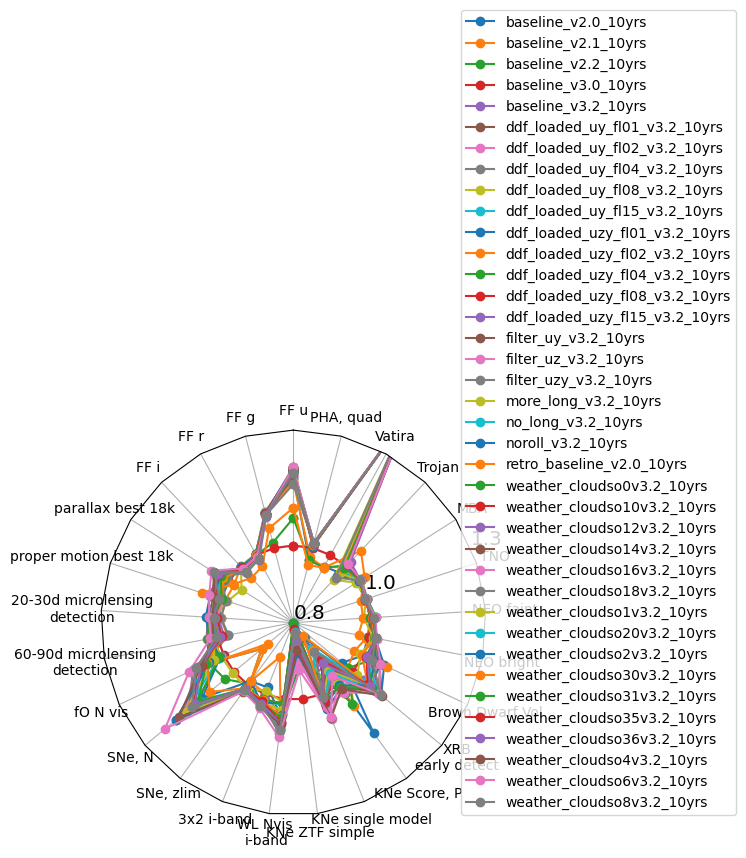

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

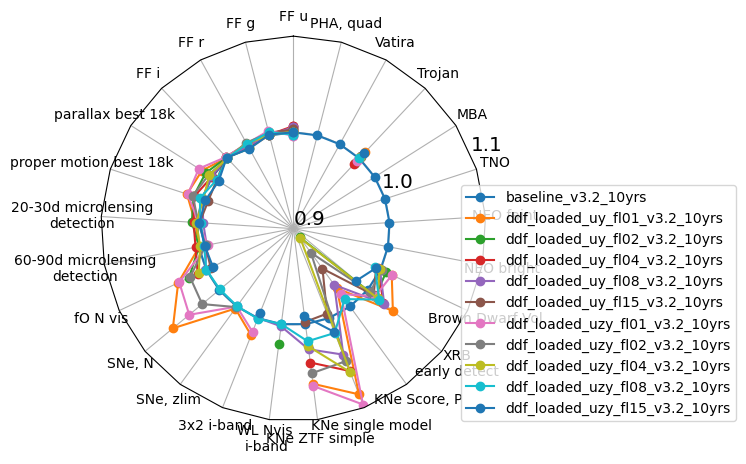

In [12]:
# DDF loaded
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf_loaded' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [13]:
data.loc[runs]

FF u      FF g      FF r      FF i  \
baseline_v3.2_10yrs             0.973633  0.982335  0.996170  0.995800   
ddf_loaded_uy_fl01_v3.2_10yrs   0.976423  0.982705  0.991847  0.996912   
ddf_loaded_uy_fl02_v3.2_10yrs   0.973075  0.986164  0.991229  0.997035   
ddf_loaded_uy_fl04_v3.2_10yrs   0.980050  0.983076  0.993576  0.997900   
ddf_loaded_uy_fl08_v3.2_10yrs   0.978795  0.982952  0.994194  0.996294   
ddf_loaded_uy_fl15_v3.2_10yrs   0.976562  0.985176  0.996541  0.998147   
ddf_loaded_uzy_fl01_v3.2_10yrs  0.970285  0.987153  0.996788  0.997900   
ddf_loaded_uzy_fl02_v3.2_10yrs  0.973633  0.984682  0.998023  0.995800   
ddf_loaded_uzy_fl04_v3.2_10yrs  0.974330  0.982582  0.997035  0.996170   
ddf_loaded_uzy_fl08_v3.2_10yrs  0.971401  0.985547  0.996418  0.996418   
ddf_loaded_uzy_fl15_v3.2_10yrs  0.973772  0.983076  0.990982  0.997035   

                                parallax best 18k  proper motion best 18k  \
baseline_v3.2_10yrs                      0.782518                0.185369   
ddf_loaded_uy_fl01_v3.2_10yrs            0.772910                0.182400   
ddf_loaded_uy_fl02_v3.2_10yrs            0.776339                0.183714   
ddf_loaded_uy_fl04_v3.2_10yrs            0.782266                0.183840   
ddf_loaded_uy_fl08_v3.2_10yrs            0.781446                0.185506   
ddf_loaded_uy_fl15_v3.2_10yrs            0.787027                0.186664   
ddf_loaded_uzy_fl01_v3.2_10yrs           0.769950                0.182583   
ddf_loaded_uzy_fl02_v3.2_10yrs           0.779156                0.183572   
ddf_loaded_uzy_fl04_v3.2_10yrs           0.779784                0.185659   
ddf_loaded_uzy_fl08_v3.2_10yrs           0.786933                0.184953   
ddf_loaded_uzy_fl15_v3.2_10yrs           0.788879                0.186104   

                                20-30d microlensing\ndetection  \
baseline_v3.2_10yrs                                     0.3430   
ddf_loaded_uy_fl01_v3.2_10yrs                           0.3453   
ddf_loaded_uy_fl02_v3.2_10yrs                           0.3487   
ddf_loaded_uy_fl04_v3.2_10yrs                           0.3469   
ddf_loaded_uy_fl08_v3.2_10yrs                           0.3369   
ddf_loaded_uy_fl15_v3.2_10yrs                           0.3406   
ddf_loaded_uzy_fl01_v3.2_10yrs                          0.3418   
ddf_loaded_uzy_fl02_v3.2_10yrs                          0.3420   
ddf_loaded_uzy_fl04_v3.2_10yrs                          0.3440   
ddf_loaded_uzy_fl08_v3.2_10yrs                          0.3396   
ddf_loaded_uzy_fl15_v3.2_10yrs                          0.3408   

                                60-90d microlensing\ndetection  fO N vis  \
baseline_v3.2_10yrs                                     0.4820     805.0   
ddf_loaded_uy_fl01_v3.2_10yrs                           0.4815     831.0   
ddf_loaded_uy_fl02_v3.2_10yrs                           0.4818     821.0   
ddf_loaded_uy_fl04_v3.2_10yrs                           0.4855     813.0   
ddf_loaded_uy_fl08_v3.2_10yrs                           0.4737     806.0   
ddf_loaded_uy_fl15_v3.2_10yrs                           0.4749     801.0   
ddf_loaded_uzy_fl01_v3.2_10yrs                          0.4728     830.0   
ddf_loaded_uzy_fl02_v3.2_10yrs                          0.4749     820.0   
ddf_loaded_uzy_fl04_v3.2_10yrs                          0.4807     812.0   
ddf_loaded_uzy_fl08_v3.2_10yrs                          0.4765     805.0   
ddf_loaded_uzy_fl15_v3.2_10yrs                          0.4758     799.0   

                                       SNe, N  ...  KNe Score, P  \
baseline_v3.2_10yrs             123176.659086  ...    234.485632   
ddf_loaded_uy_fl01_v3.2_10yrs   130880.549286  ...    228.997487   
ddf_loaded_uy_fl02_v3.2_10yrs             NaN  ...    213.637731   
ddf_loaded_uy_fl04_v3.2_10yrs             NaN  ...    193.983678   
ddf_loaded_uy_fl08_v3.2_10yrs             NaN  ...    227.977221   
ddf_loaded_uy_fl15_v3.2_10yrs             NaN  ...    223.101880   
ddf_loaded_uzy_fl01_v3.2_10yrs  128158.4

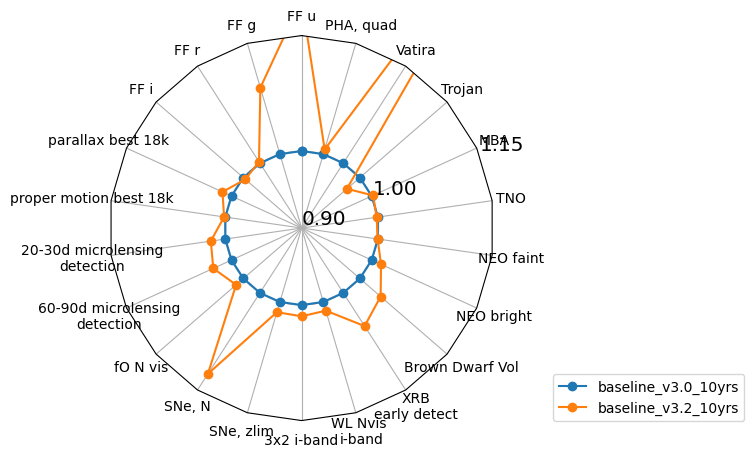

In [23]:
runs = ['baseline_v3.0_10yrs', 'baseline_v3.2_10yrs'] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')

for col in ndata.columns:
    if 'KNe' in col:
        ndata = ndata.drop(labels=col, axis=1)

fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.15], bbox_to_anchor=(1.65, 0))

In [20]:
ndata.columns

Index(['FF u', 'FF g', 'FF r', 'FF i', 'parallax best 18k',
       'proper motion best 18k', '20-30d microlensing\ndetection',
       '60-90d microlensing\ndetection', 'fO N vis', 'SNe, N', 'SNe, zlim',
       '3x2 i-band', 'WL Nvis \ni-band', 'KNe ZTF simple', 'KNe single model',
       'KNe Score, P', 'XRB\nearly detect', 'Brown Dwarf Vol', 'NEO bright',
       'NEO faint', 'TNO', 'MBA', 'Trojan', 'Vatira', 'PHA, quad'],
      dtype='object')

In [14]:
data['Vatira']

baseline_v2.0_10yrs               0.0039
baseline_v2.1_10yrs               0.0017
baseline_v2.2_10yrs               0.0008
baseline_v3.0_10yrs               0.0376
baseline_v3.2_10yrs               0.4628
ddf_loaded_uy_fl01_v3.2_10yrs        NaN
ddf_loaded_uy_fl02_v3.2_10yrs        NaN
ddf_loaded_uy_fl04_v3.2_10yrs        NaN
ddf_loaded_uy_fl08_v3.2_10yrs        NaN
ddf_loaded_uy_fl15_v3.2_10yrs        NaN
ddf_loaded_uzy_fl01_v3.2_10yrs       NaN
ddf_loaded_uzy_fl02_v3.2_10yrs       NaN
ddf_loaded_uzy_fl04_v3.2_10yrs       NaN
ddf_loaded_uzy_fl08_v3.2_10yrs       NaN
ddf_loaded_uzy_fl15_v3.2_10yrs       NaN
filter_uy_v3.2_10yrs              0.4628
filter_uz_v3.2_10yrs              0.4597
filter_uzy_v3.2_10yrs             0.4627
more_long_v3.2_10yrs              0.4618
no_long_v3.2_10yrs                0.4653
noroll_v3.2_10yrs                 0.4621
retro_baseline_v2.0_10yrs         0.0000
weather_cloudso0v3.2_10yrs        0.4628
weather_cloudso10v3.2_10yrs       0.4582
weather_cloudso1

In [15]:
ddf_data

N SN COSMOS   N SN ECDFS    N SN EDFS  \
baseline_v2.0_10yrs              638.253284   586.826209   974.231557   
baseline_v2.1_10yrs              548.479625   545.669910   875.981802   
baseline_v2.2_10yrs              708.239238   685.202422  1067.553931   
baseline_v3.0_10yrs              955.159293   799.584601  1266.961769   
baseline_v3.2_10yrs              971.481238   868.593513  1528.851192   
ddf_loaded_uy_fl01_v3.2_10yrs    857.379633   706.813786  1268.470459   
ddf_loaded_uy_fl02_v3.2_10yrs    992.720699   914.078093  1523.082694   
ddf_loaded_uy_fl04_v3.2_10yrs   1077.527601  1047.846424  1631.013584   
ddf_loaded_uy_fl08_v3.2_10yrs   1163.416261  1113.221455  1692.126968   
ddf_loaded_uy_fl15_v3.2_10yrs   1201.092034  1167.865557  1761.117457   
ddf_loaded_uzy_fl01_v3.2_10yrs   859.471823   734.550770  1232.464265   
ddf_loaded_uzy_fl02_v3.2_10yrs   980.423642   936.398009  1478.748433   
ddf_loaded_uzy_fl04_v3.2_10yrs  1104.006281  1059.583509  1683.163078   
ddf_loaded_uzy_fl08_v3.2_10yrs  1163.600118  1130.550249  1735.787310   
ddf_loaded_uzy_fl15_v3.2_10yrs  1200.984999  1154.566214  1796.542082   
filter_uy_v3.2_10yrs             971.481238   868.593513  1528.851192   
filter_uz_v3.2_10yrs             910.523965   827.904127  1419.493359   
filter_uzy_v3.2_10yrs           1021.279625   957.001932  1620.836596   
more_long_v3.2_10yrs             964.067639   848.184107  1478.167236   
no_long_v3.2_10yrs               979.067169   845.163011  1519.301358   
noroll_v3.2_10yrs               1050.425362  1007.677308  1587.404524   
retro_baseline_v2.0_10yrs        633.216869   678.859654  1098.712998   
weather_cloudso0v3.2_10yrs       971.481238   868.593513  1528.851192   
weather_cloudso10v3.2_10yrs      915.437009   792.371507  1339.484181   
weather_cloudso12v3.2_10yrs      919.724914   800.319285  1408.837954   
weather_cloudso14v3.2_10yrs      906.029032   745.630159  1352.836413   
weather_cloudso16v3.2_10yrs      918.713736   838.506381  1339.605101   
weather_cloudso18v3.2_10yrs      935.778502   782.702897  1252.108674   
weather_cloudso1v3.2_10yrs      1001.516642   893.046247  1509.373570   
weather_cloudso20v3.2_10yrs      929.356999   819.961607  1267.849236   
weather_cloudso2v3.2_10yrs       983.765904   888.313646  1493.988770   
weather_cloudso30v3.2_10yrs      918.974166   767.300533  1235.419923   
weather_cloudso31v3.2_10yrs      923.929027   758.751066  1331.837696   
weather_cloudso35v3.2_10yrs      905.093131   819.963739  1318.210628   
weather_cloudso36v3.2_10yrs      952.812961   782.900660  1273.781076   
weather_cloudso4v3.2_10yrs       941.690097   873.951250  1495.992237   
weather_cloudso6v3.2_10yrs       993.185144   851.208253  1534.867682   
weather_cloudso8v3.2_10yrs       957.641748   786.334094  1440.354745   

                                N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
baseline_v2.0_10yrs               684.401547    611.229060     0.503926   
baseline_v2.1_10yrs               636.634918    520.071105     0.496150   
baseline_v2.2_10yrs               674.561648    611.247120     0.493897   
baseline_v3.0_10yrs               688.808879    726.491723     0.503734   
baseline_v3.2_10yrs               844.740564    840.405268     0.510969   
ddf_loaded_uy_fl01_v3.2_10yrs     724.569064    687.336475     0.466919   
ddf_loaded_uy_fl02_v3.2_10yrs     932.828685    906.642949     0.503710   
ddf_loaded_uy_fl04_v3.2_10yrs    1045.497643   1028.435573     0.509452   
ddf_loaded_uy_fl08_v3.2_10yrs    1122.878883   1138.515972     0.504923   
ddf_loaded_uy_fl15_v3.2_10yrs    1190.489082   1183.033967     0.510976   
ddf_loaded_uzy_fl01_v3.2_10yrs    695.366535    701.183309     0.474545   
ddf_loaded_uzy_fl02_v3.2_10yrs    939.233923    903.573361     0.497121   
ddf_loaded_uzy_fl04_v3.2_10yrs   1067.572407   1070.932614     0.505965   
ddf_loaded_uzy_fl08_v3.2_10yrs   1185.240468   1166.376672     0.510617   
ddf_loaded_uzy_fl15_v3.2_10yrs   1185.634021   1167.526718 

In [16]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



FF u      FF g      FF r      FF i  \
retro_baseline_v2.0_10yrs  0.893276  0.949104  0.960964  0.958616   
baseline_v2.0_10yrs        0.955776  0.981594  0.994441  0.997035   
baseline_v2.1_10yrs        0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs        0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs        0.813058  0.901174  0.993823  0.999135   
baseline_v3.2_10yrs        0.973633  0.982335  0.996170  0.995800   

                           parallax best 18k  proper motion best 18k  \
retro_baseline_v2.0_10yrs           0.804328                0.176701   
baseline_v2.0_10yrs                 0.791058                0.184088   
baseline_v2.1_10yrs                 0.806910                0.188258   
baseline_v2.2_10yrs                 0.792958                0.186345   
baseline_v3.0_10yrs                 0.792666                0.185683   
baseline_v3.2_10yrs                 0.782518                0.185369   

                           20-30d microlensing\ndetection  \
retro_baseline_v2.0_10yrs                          0.0883   
baseline_v2.0_10yrs                                0.3116   
baseline_v2.1_10yrs                                0.3111   
baseline_v2.2_10yrs                                0.3212   
baseline_v3.0_10yrs                                0.3239   
baseline_v3.2_10yrs                                0.3430   

                           60-90d microlensing\ndetection  fO N vis  \
retro_baseline_v2.0_10yrs                          0.1533     848.0   
baseline_v2.0_10yrs                                0.4284     839.0   
baseline_v2.1_10yrs                                0.4312     838.0   
baseline_v2.2_10yrs                                0.4462     830.0   
baseline_v3.0_10yrs                                0.4559     795.0   
baseline_v3.2_10yrs                                0.4820     805.0   

                                  SNe, N  ...  KNe Score, P  \
retro_baseline_v2.0_10yrs   97124.012102  ...    202.730488   
baseline_v2.0_10yrs         99302.532220  ...    263.696398   
baseline_v2.1_10yrs         99294.339899  ...    243.713720   
baseline_v2.2_10yrs        112802.099640  ...    242.377184   
baseline_v3.0_10yrs        109475.798536  ...    228.428876   
baseline_v3.2_10yrs        123176.659086  ...    234.485632   

                           XRB\nearly detect  Brown Dwarf Vol  NEO bright  \
retro_baseline_v2.0_10yrs              720.0    179640.718155      0.9048   
baseline_v2.0_10yrs                   1879.0    168086.074111      0.9294   
baseline_v2.1_10yrs                   1918.0    163815.013503      0.9286   
baseline_v2.2_10yrs                   1920.0    172453.127988      0.9304   
baseline_v3.0_10yrs                   1950.0    168032.537231      0.9326   
baseline_v3.2_10yrs                   2050.0    174053.517478      0.9460   

                           NEO faint       TNO       MBA    Trojan  Vatira  \
retro_baseline_v2.0_10yrs   0.623933  0.705953  0.943433  0.667158  0.0000   
baseline_v2.0_10yrs         0.642021  0.719635  0.918999  0.588087  0.0039   
baseline_v2.1_10yrs         0.647553  0.723197  0.927567  0.608979  0.0017   
baseline_v2.2_10yrs         0.657462  0.723899  0.933507  0.615249  0.0008   
baseline_v3.0_10yrs         0.642155  0.722293  0.924156  0.611053  0.0376   
baseline_v3.2_10yrs         0.641896  0.720793  0.926248  0.588856  0.4628   

                           PHA, quad  
retro_baseline_v2.0_10yrs   0.847880  
baseline_v2.0_10yrs         0.859238  
baseline_v2.1_10yrs         0.865438  
baseline_v2.2_10yrs         0.858538  
baseline_v3.0_10yrs         0.887938  
baseline_v3.2_10yrs         0.893584  

[6 rows x 25 columns]

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


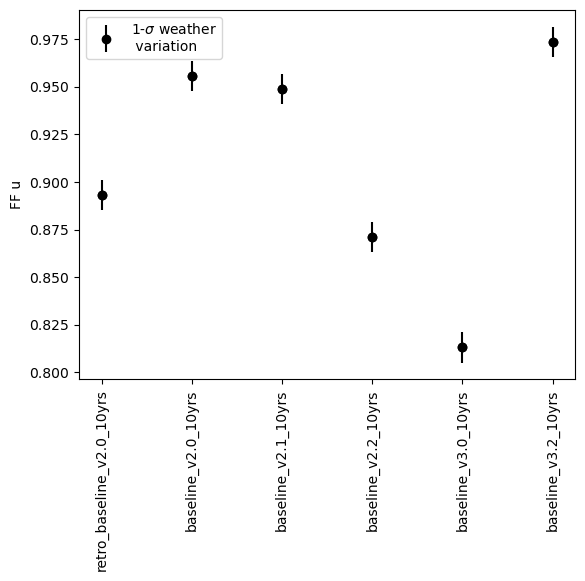

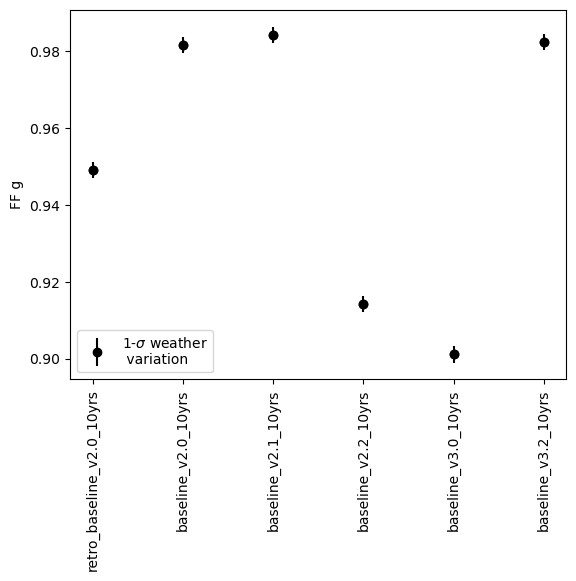

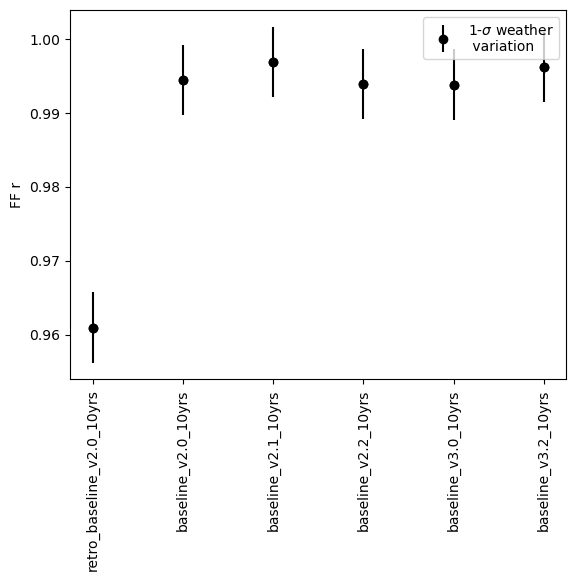

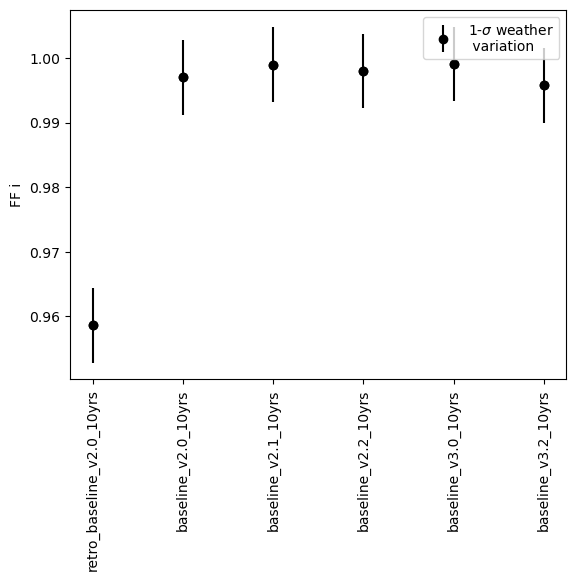

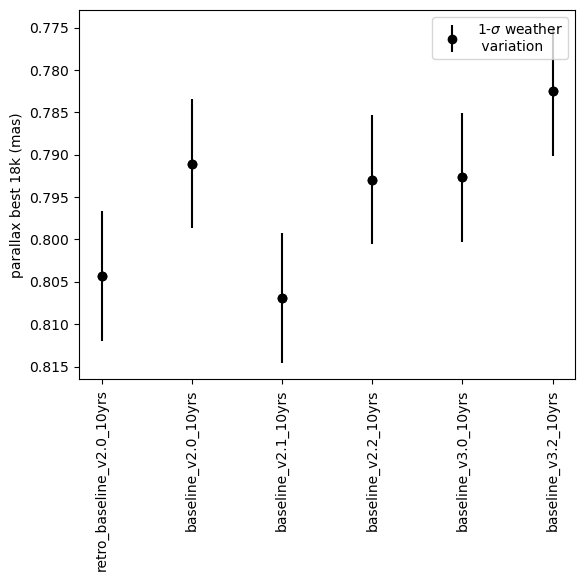

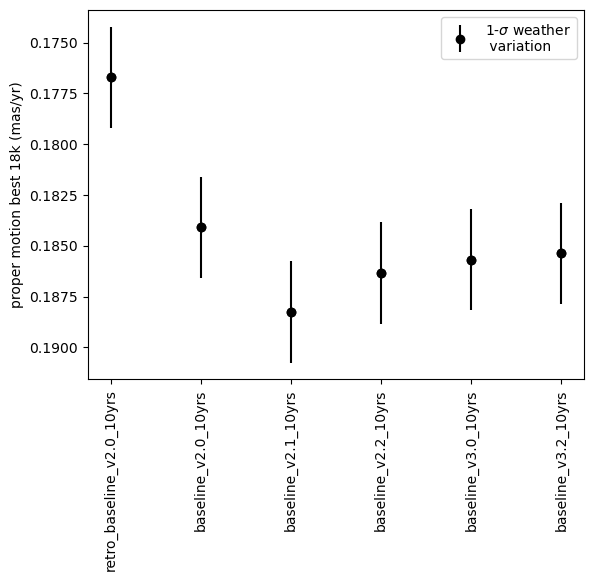

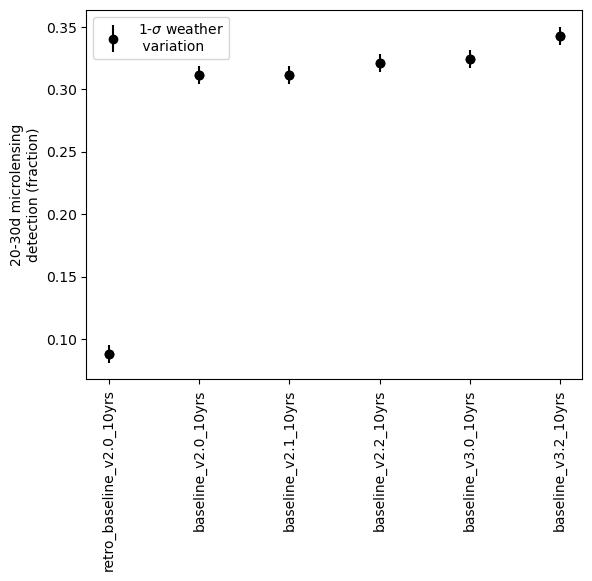

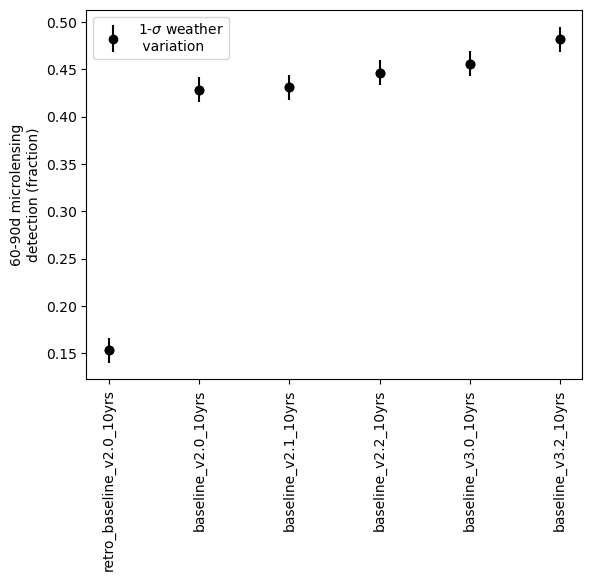

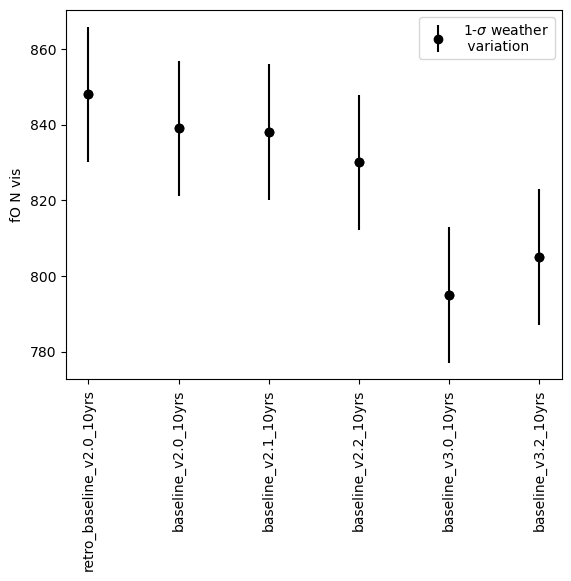

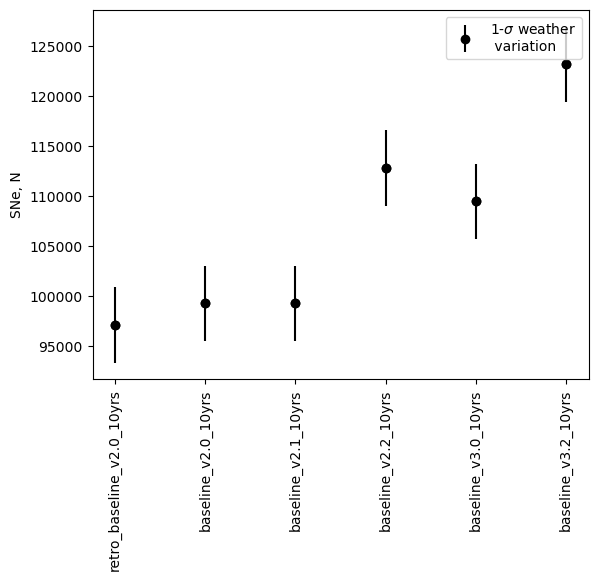

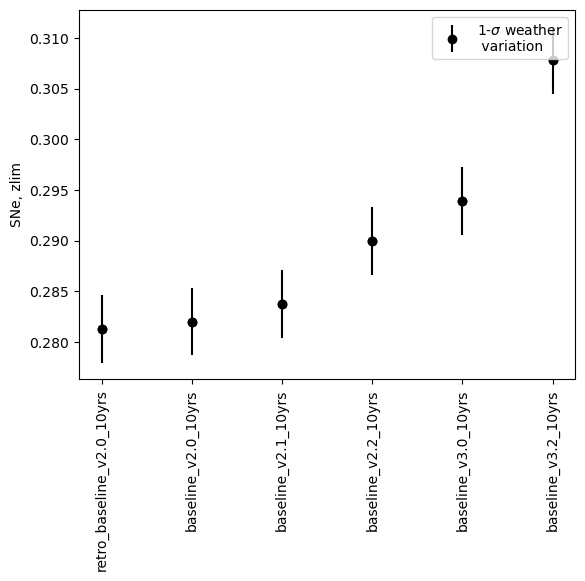

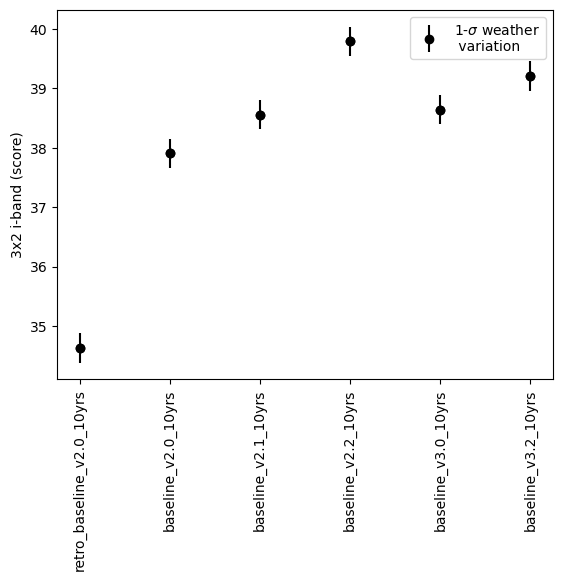

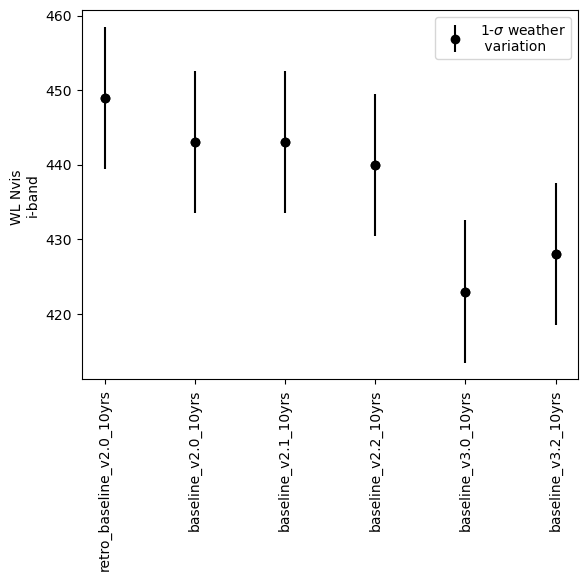

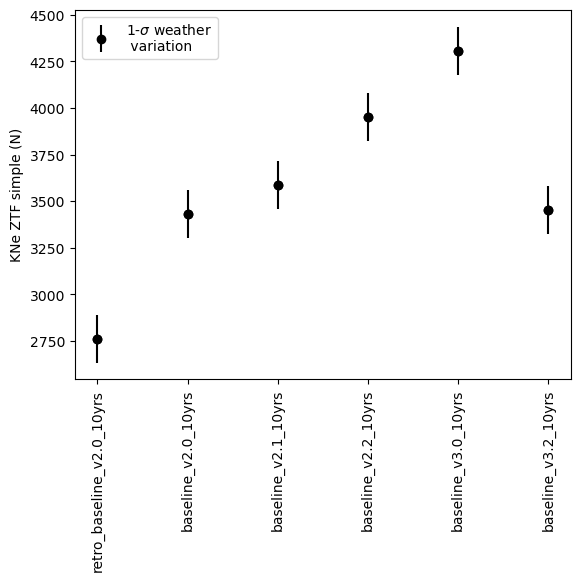

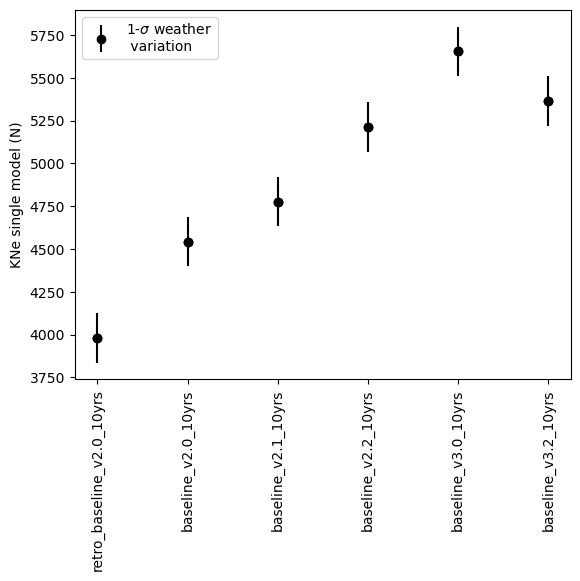

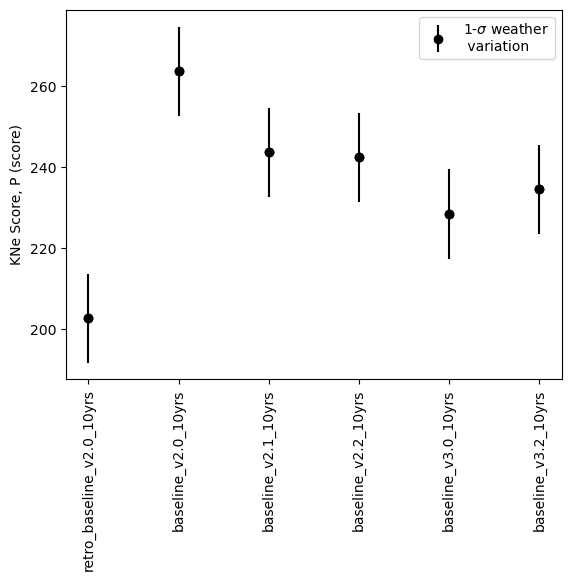

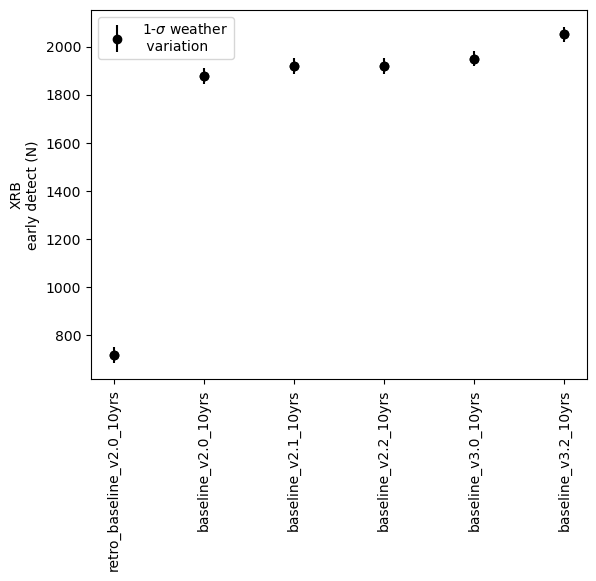

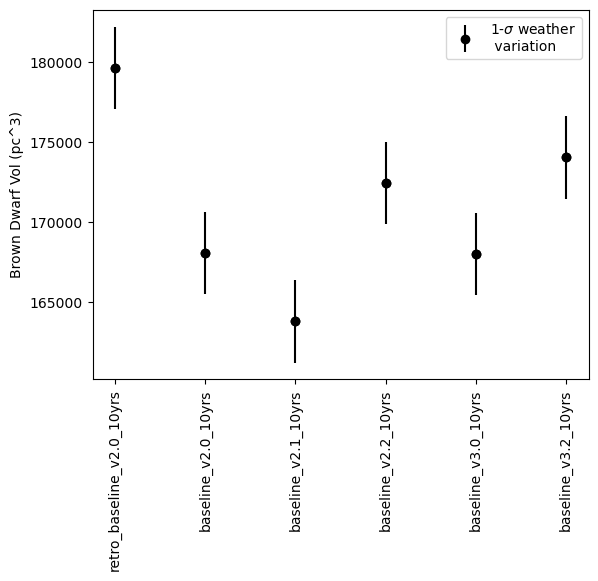

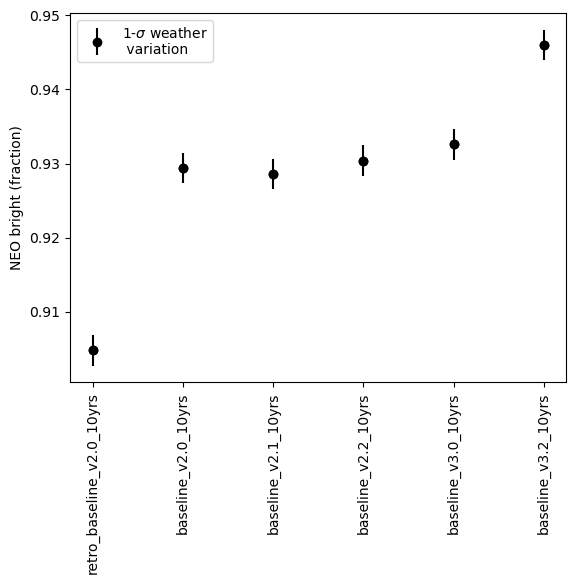

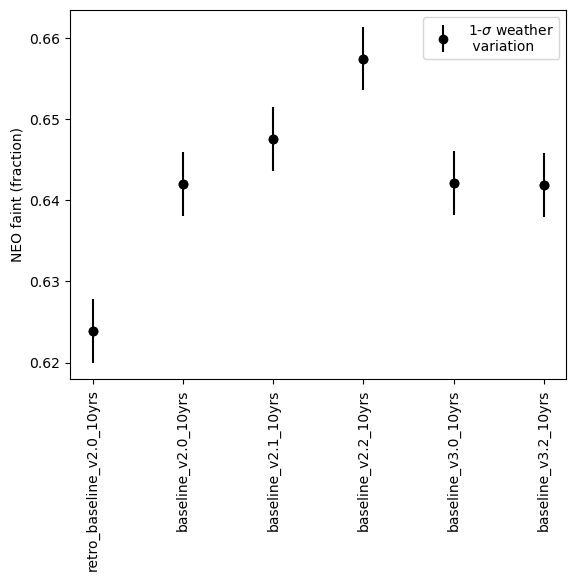

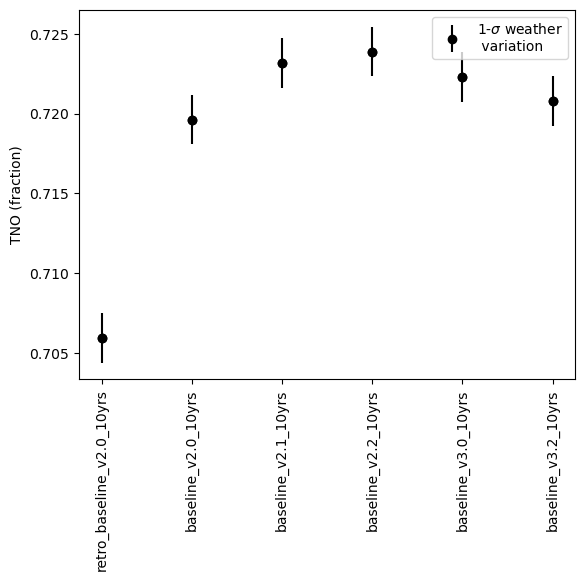

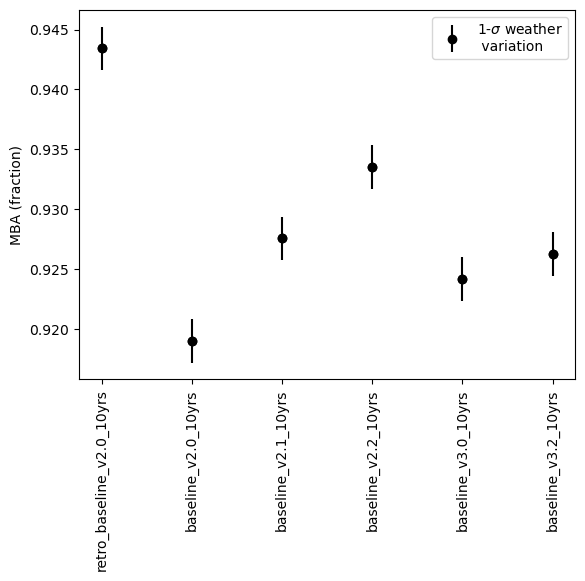

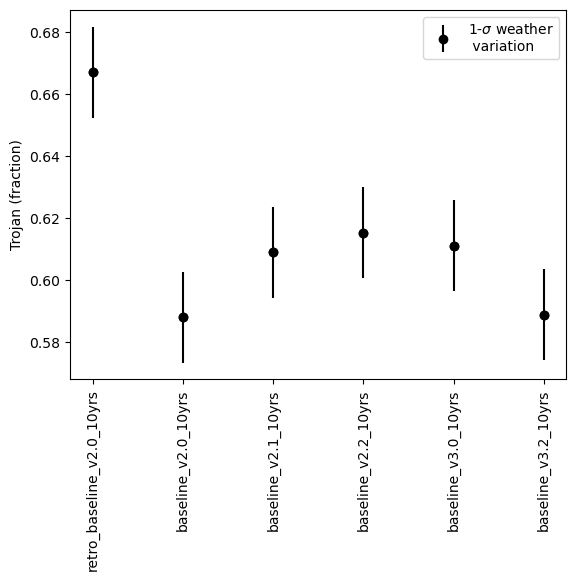

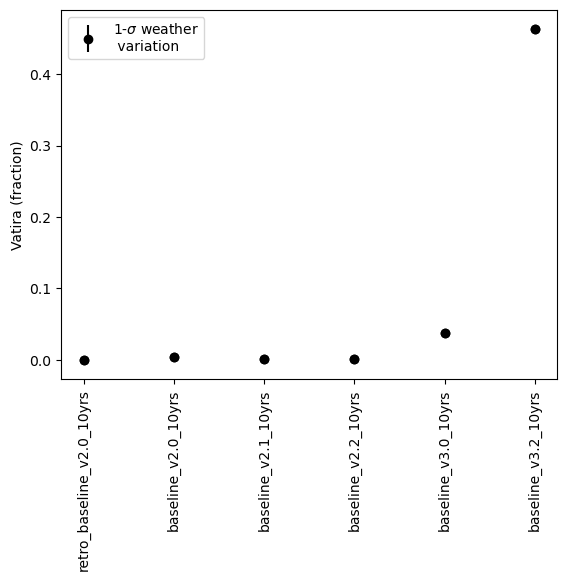

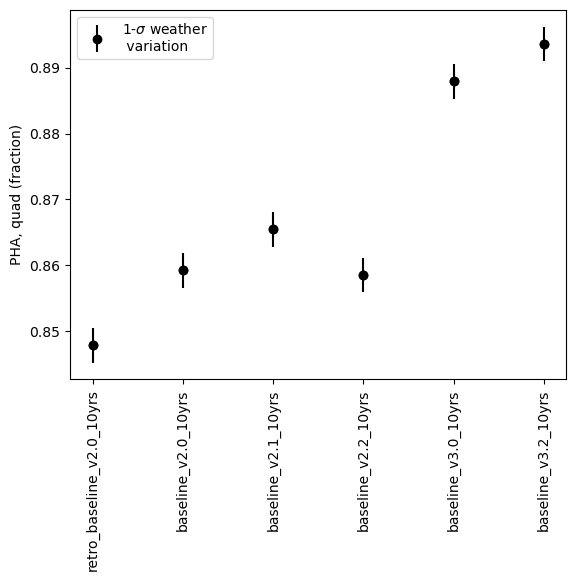

In [17]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


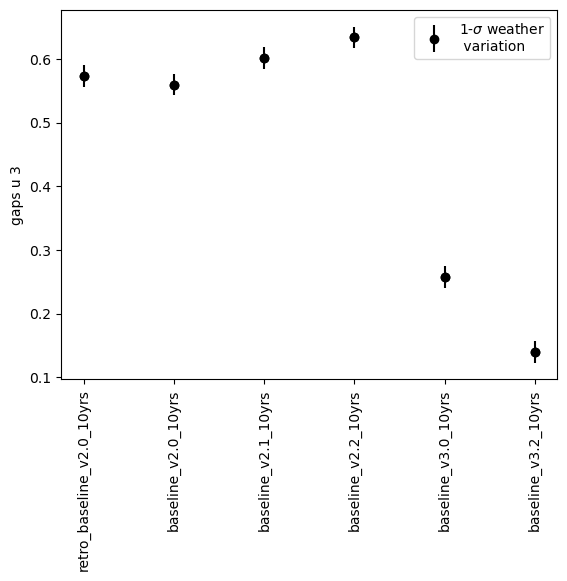

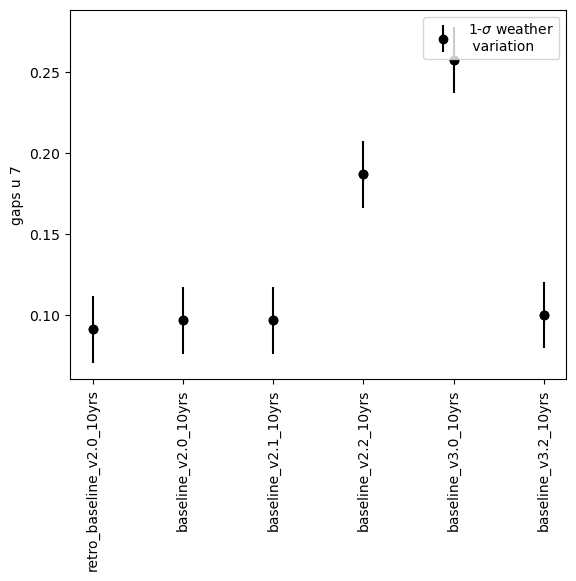

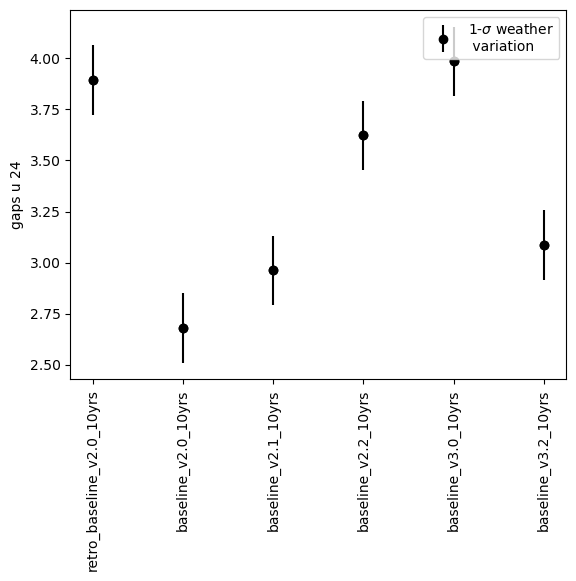

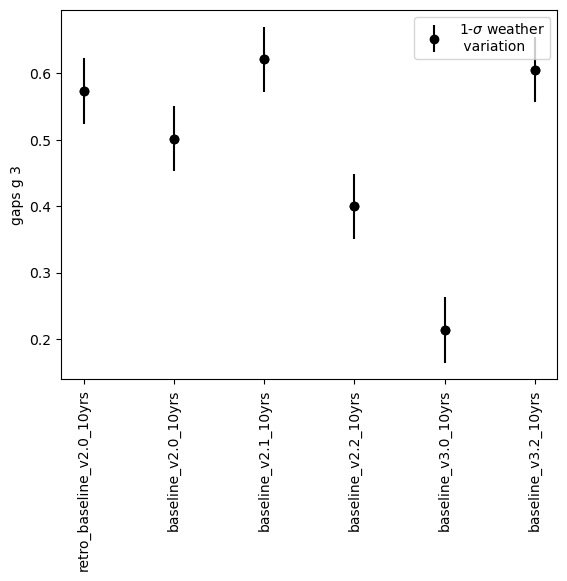

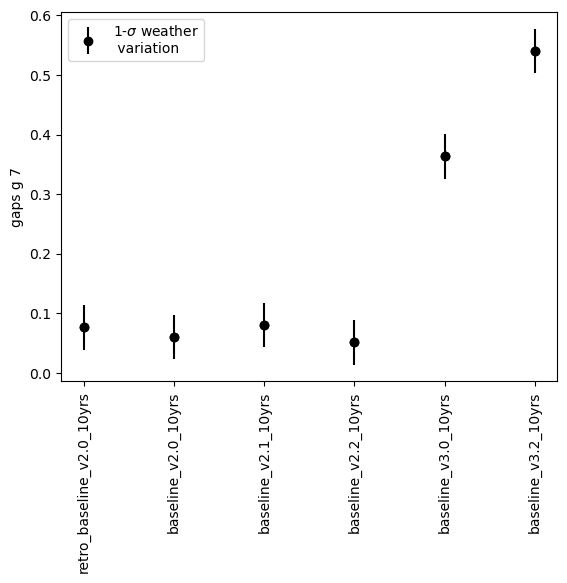

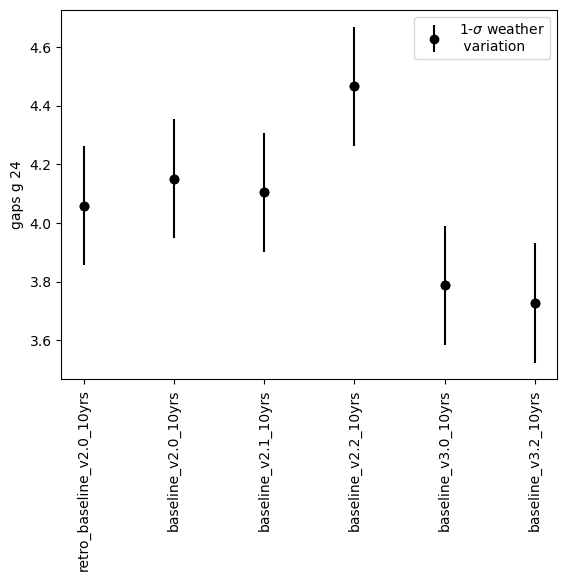

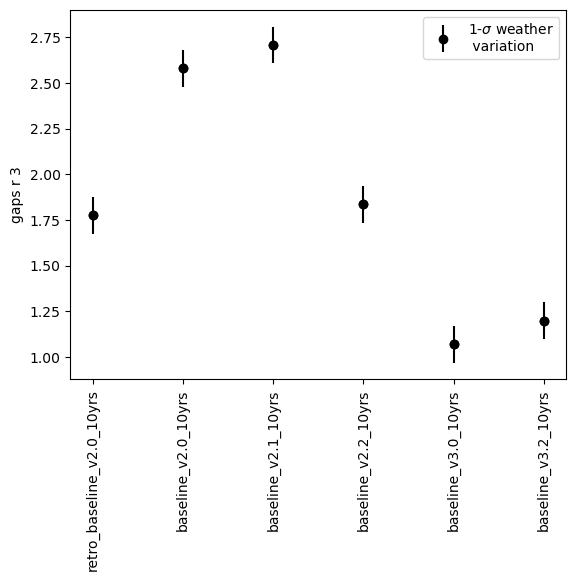

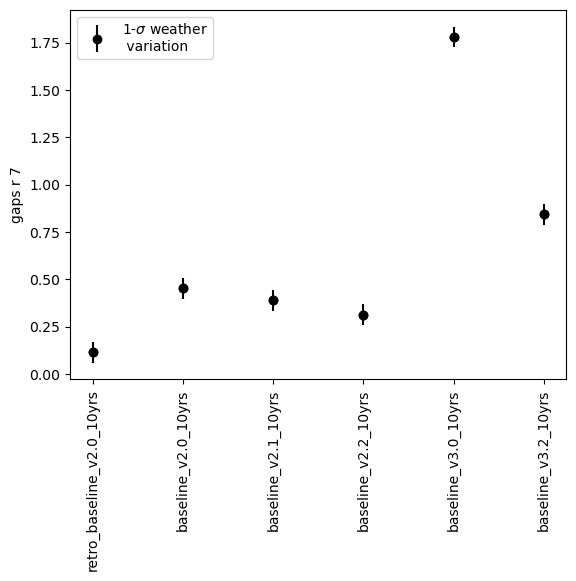

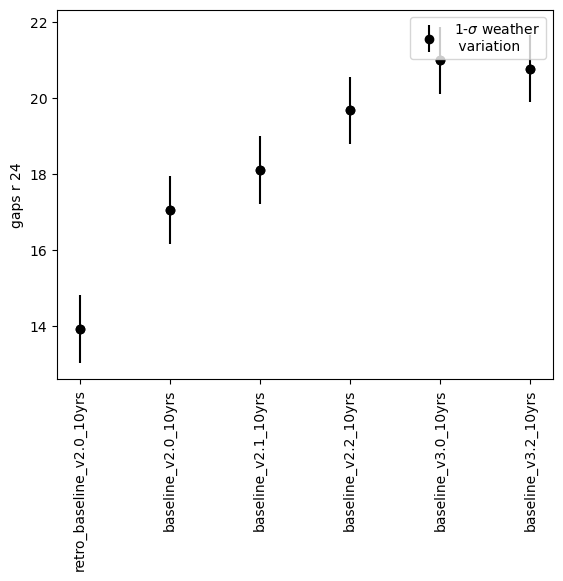

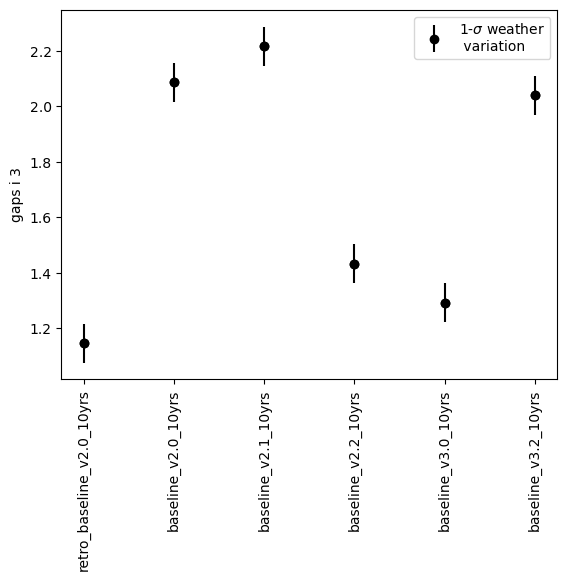

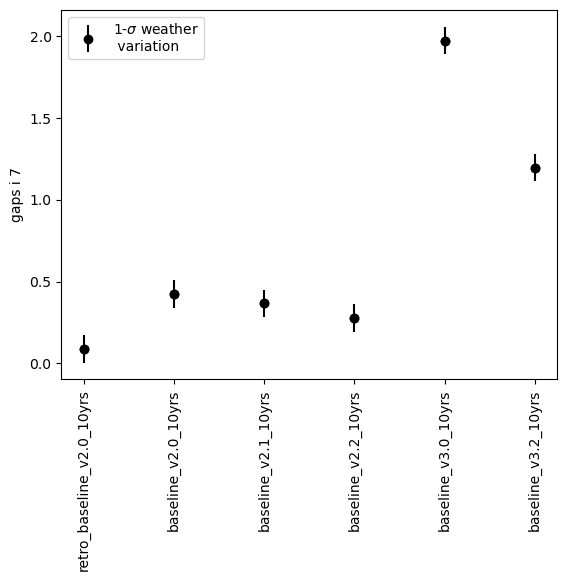

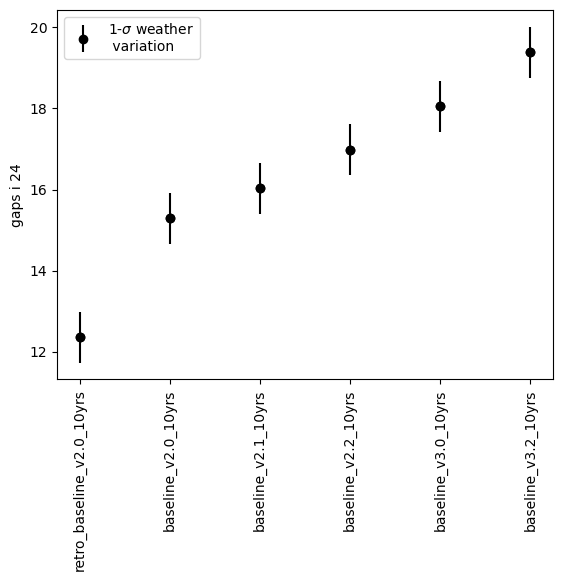

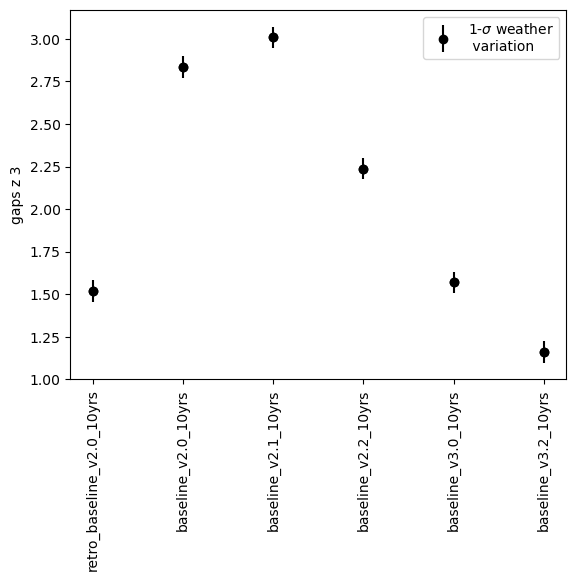

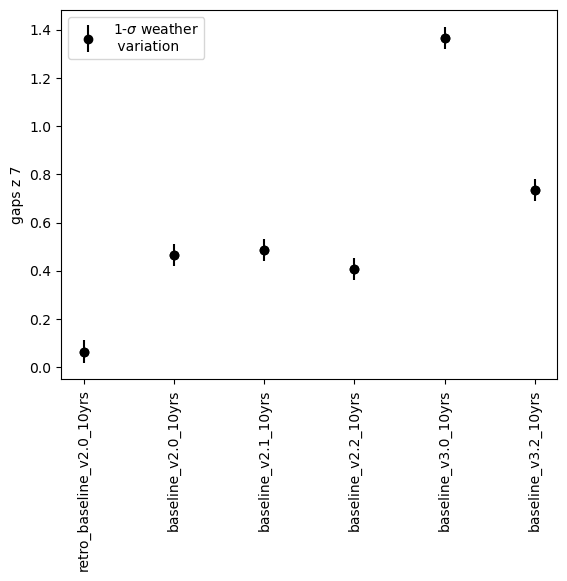

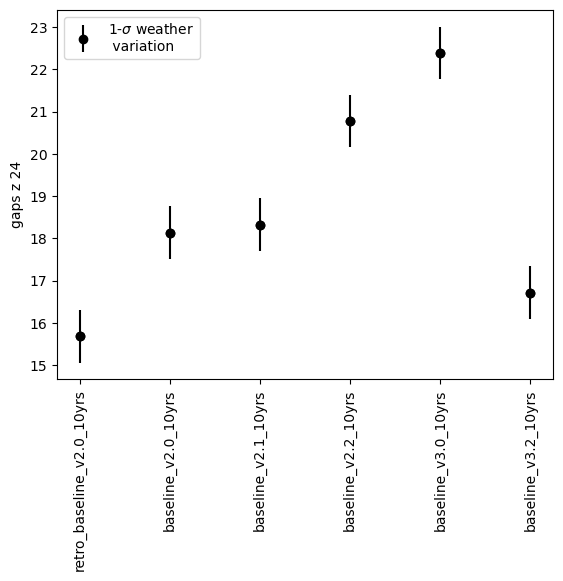

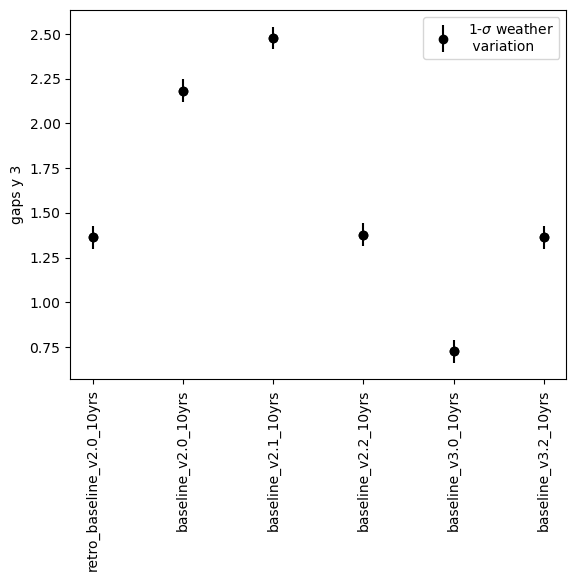

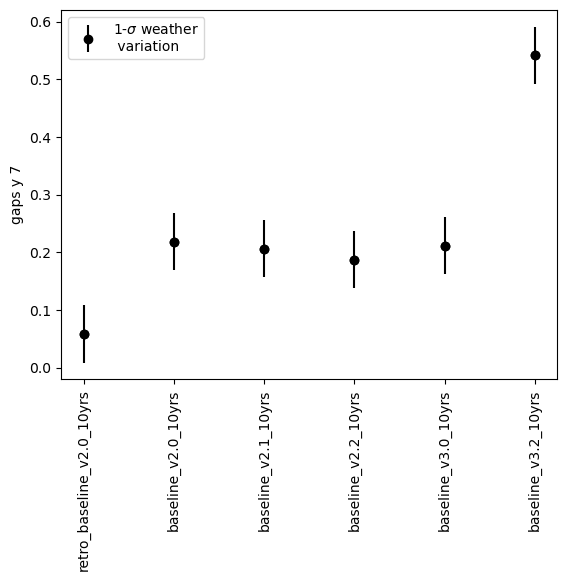

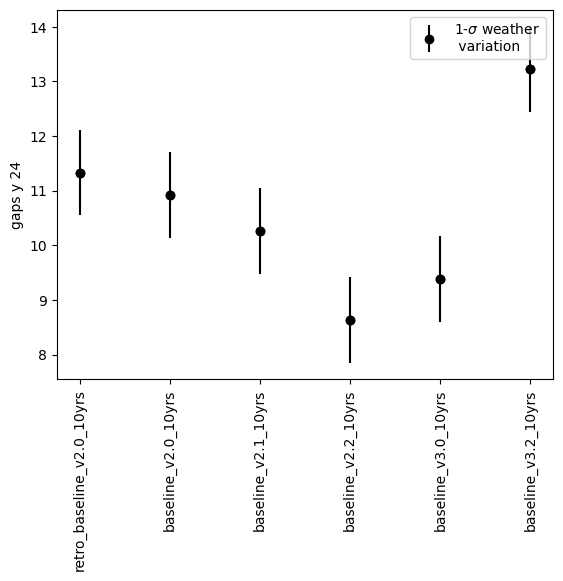

In [18]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


In [19]:
# so, we can think about what summary stats make the most sense for gaps. Might be top 18k sq degrees

In [20]:
times = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'filter' in run and 'short' not in run]
sub_gaps = gaps_data.reindex(labels=times)


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


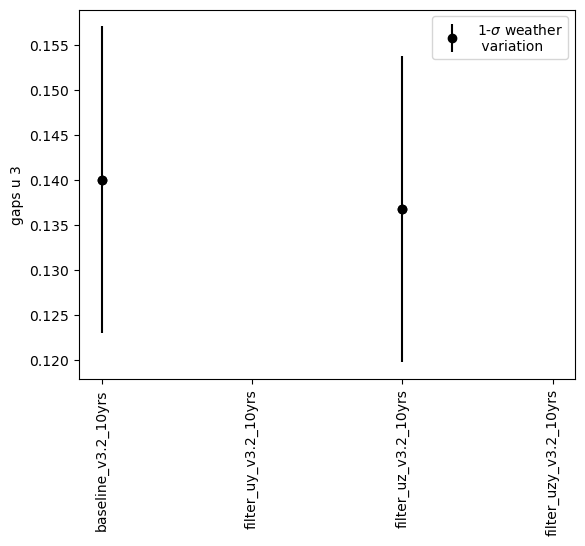

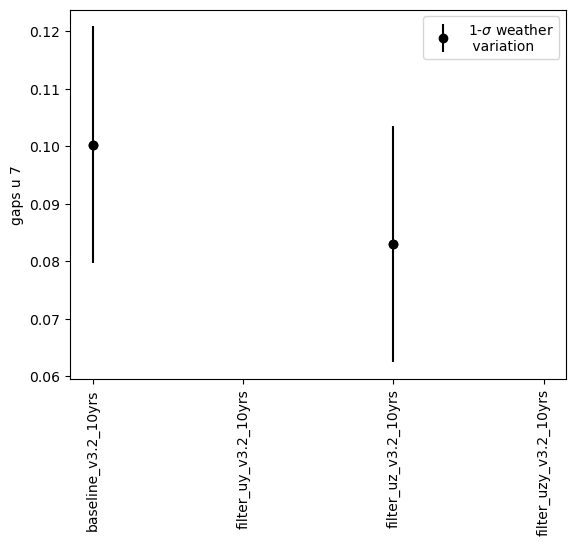

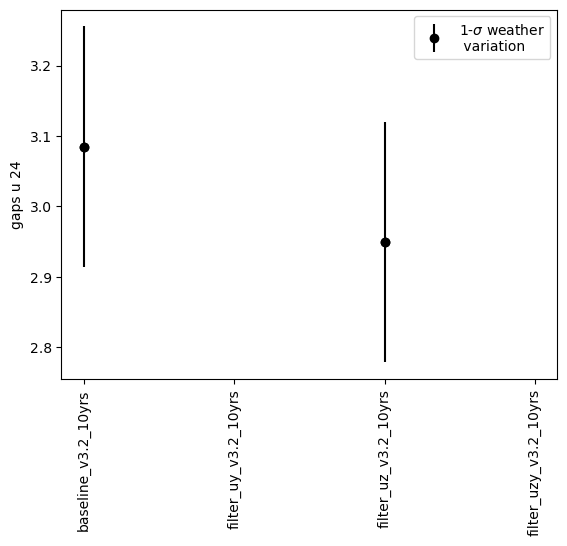

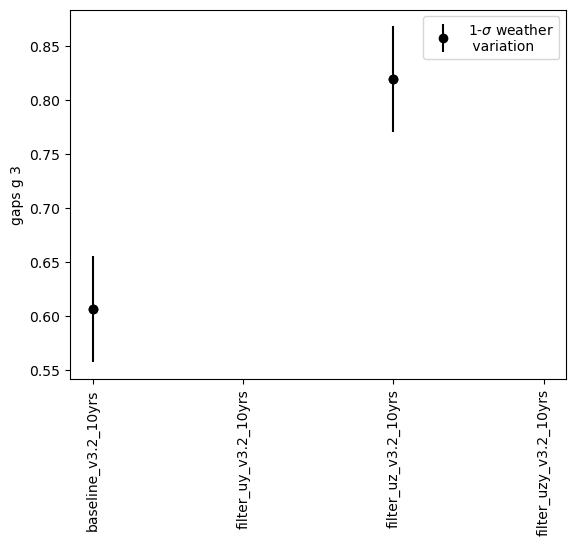

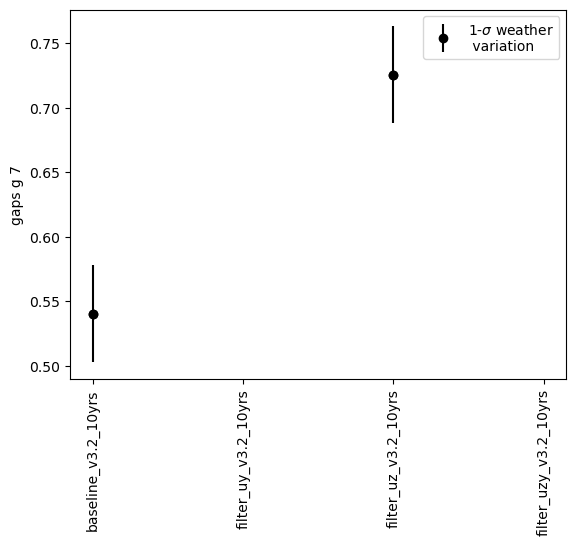

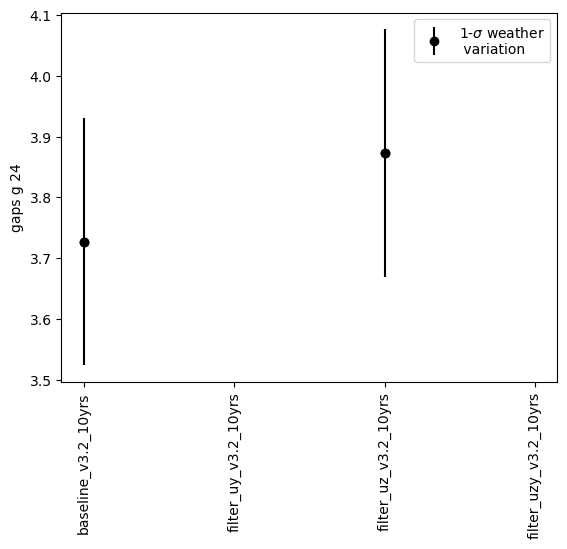

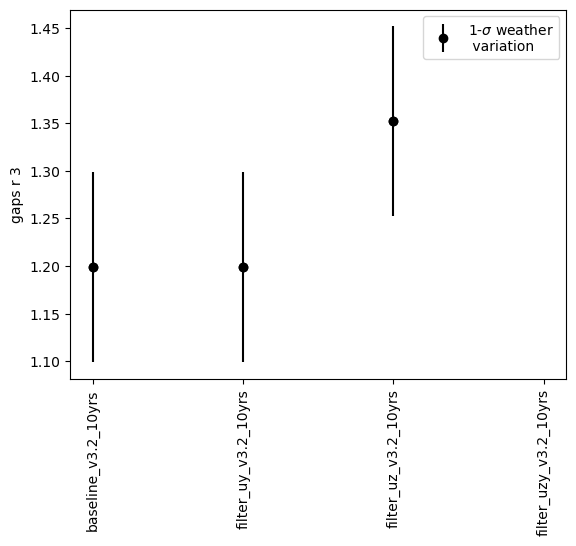

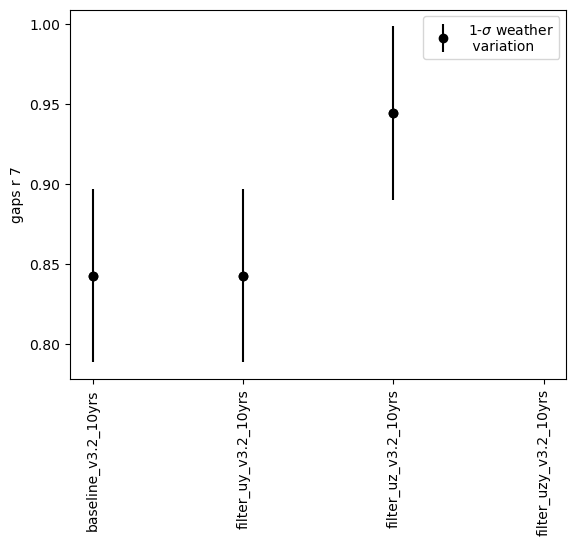

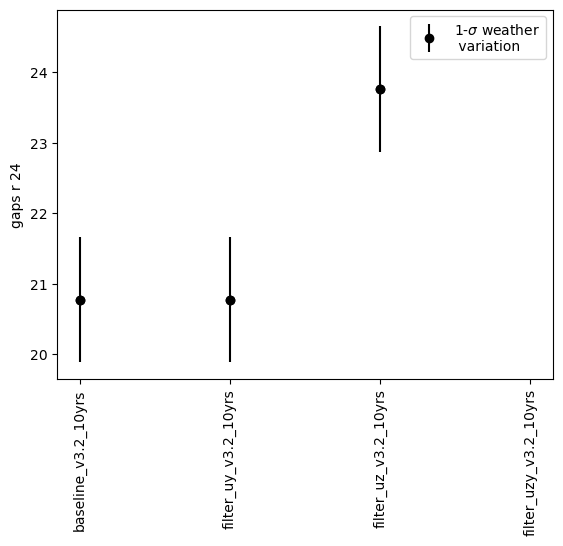

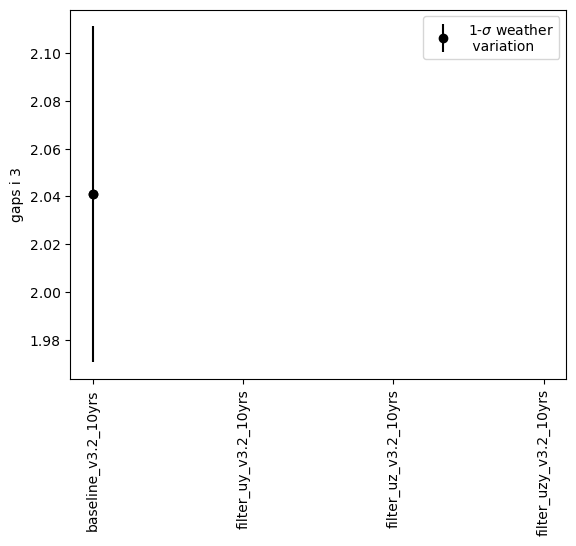

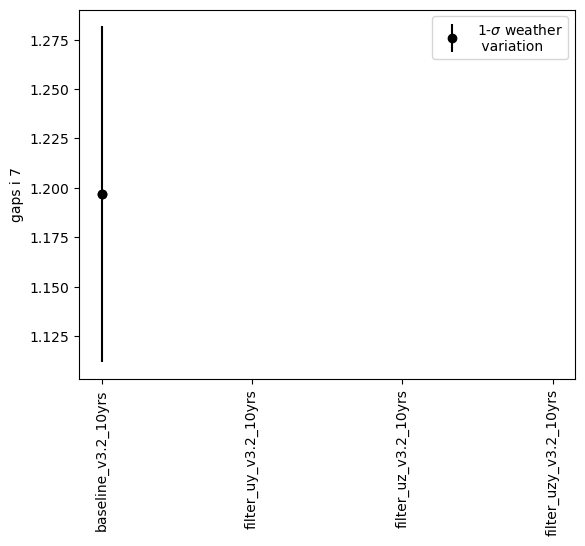

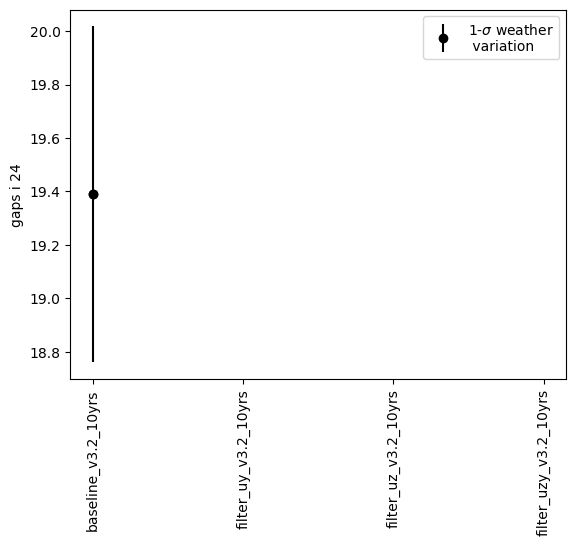

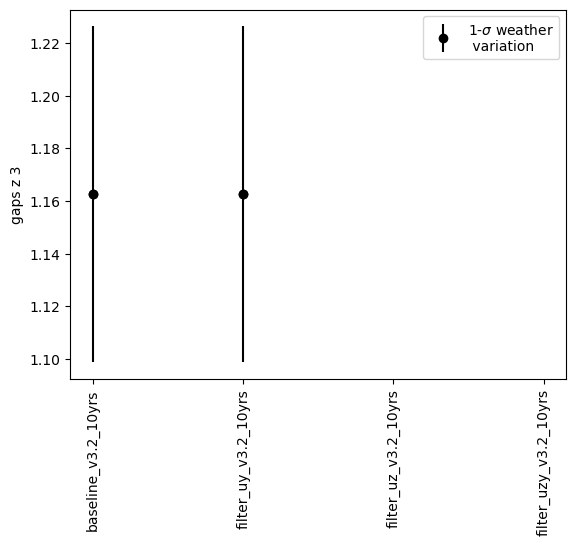

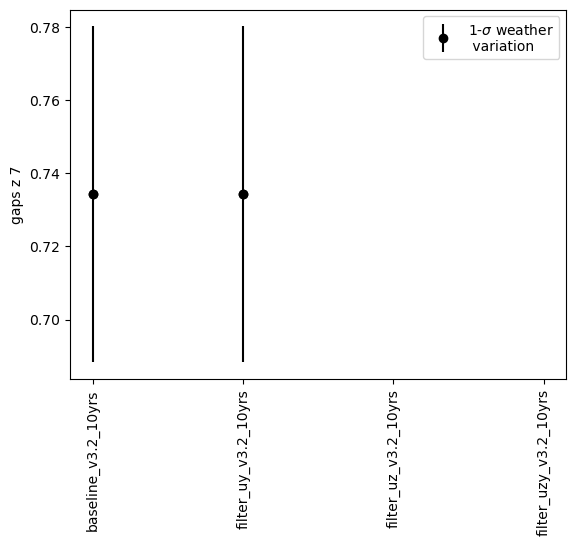

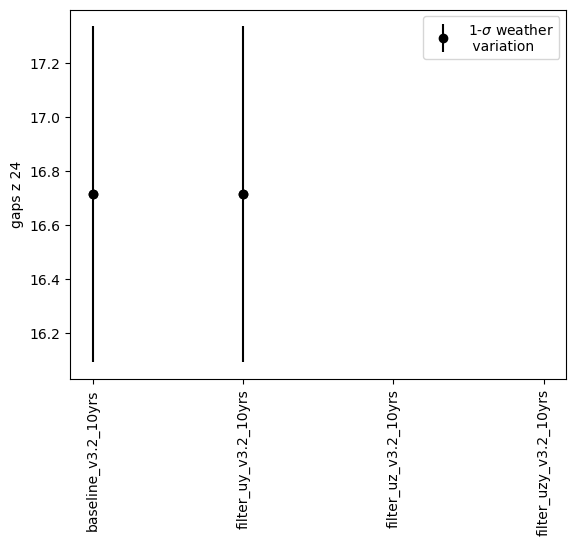

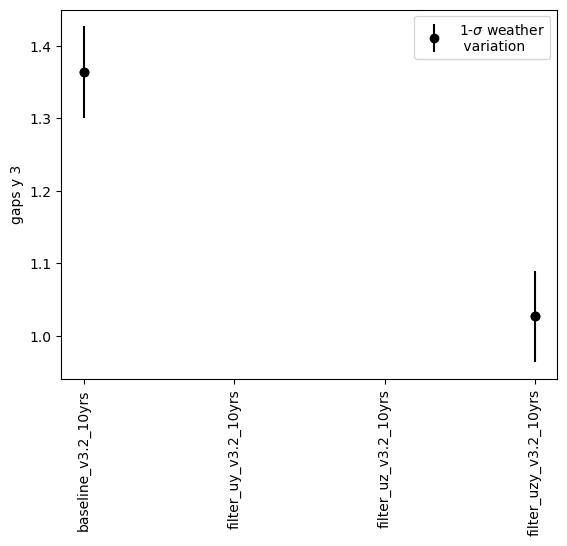

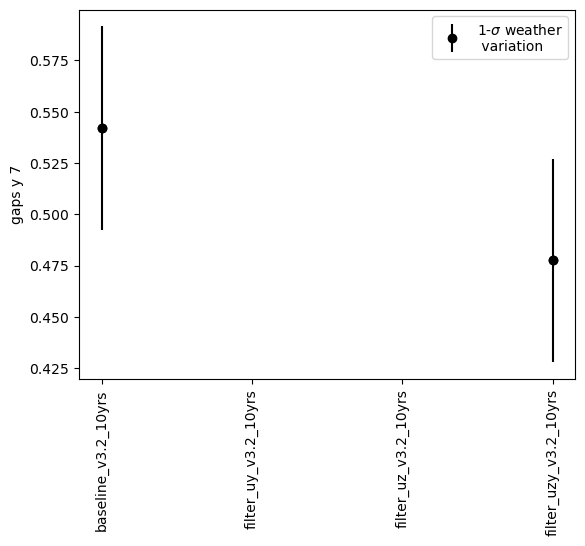

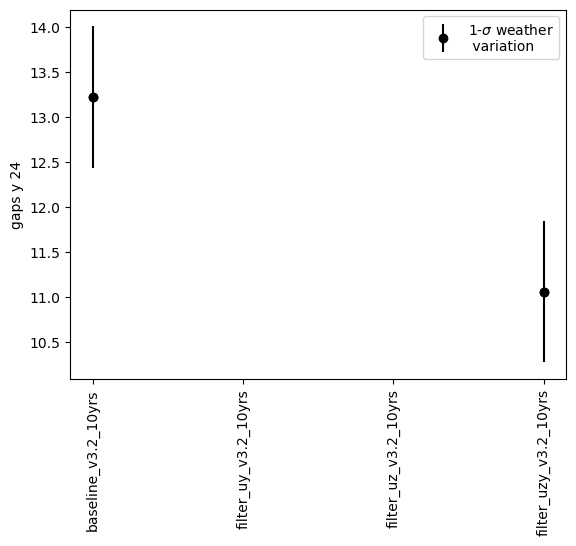

In [21]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/526031158.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


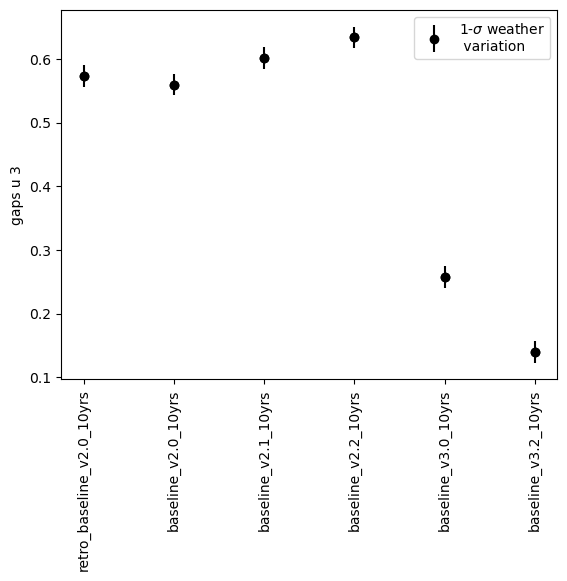

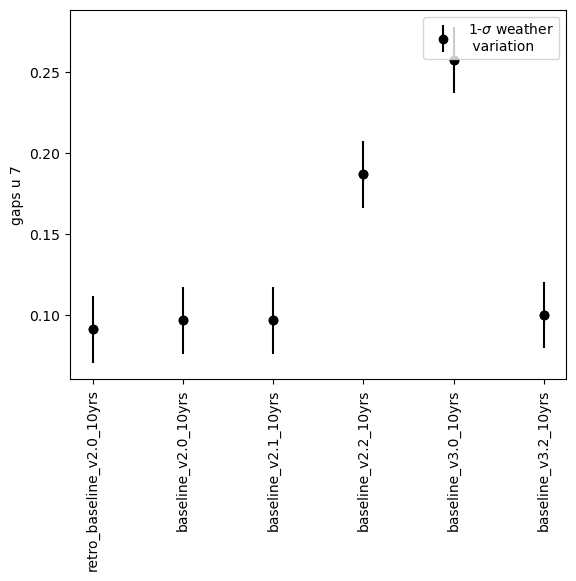

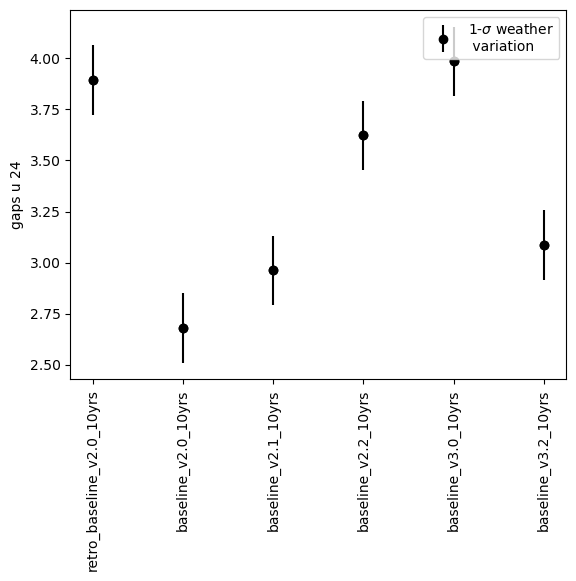

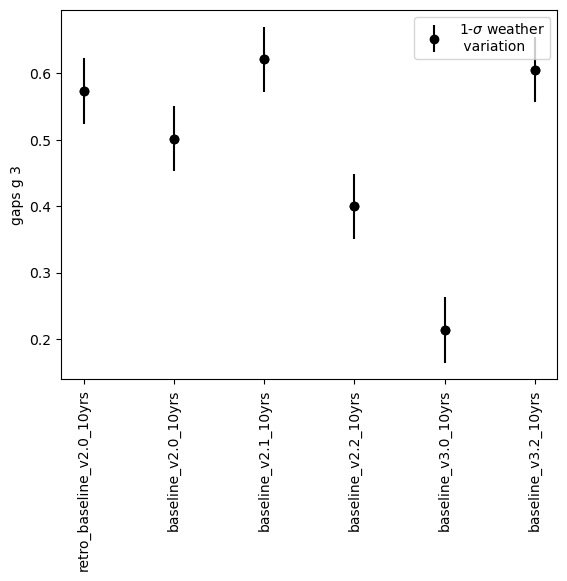

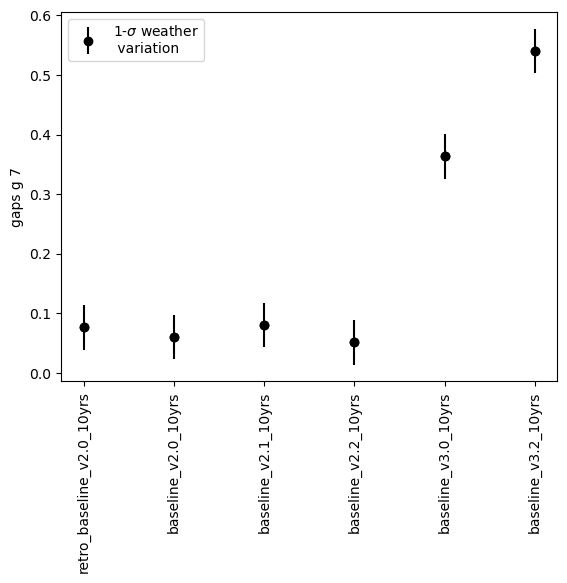

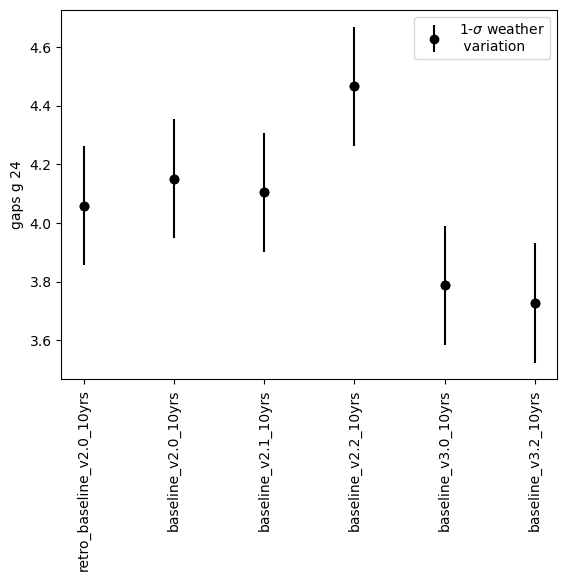

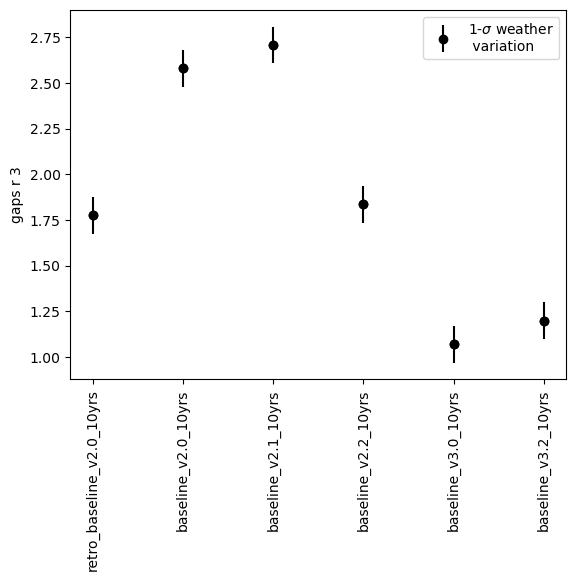

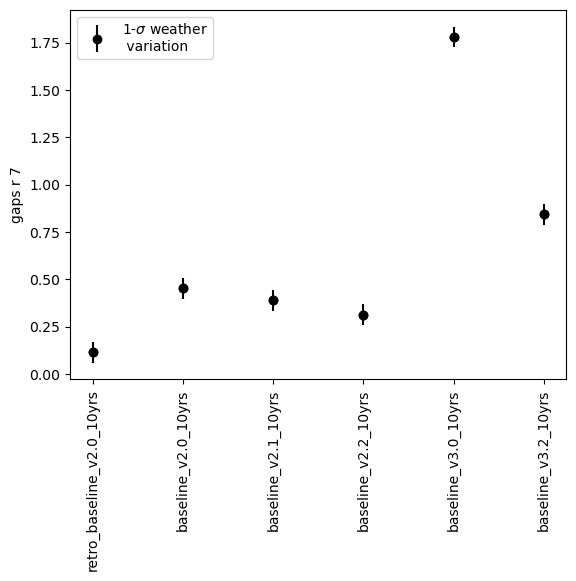

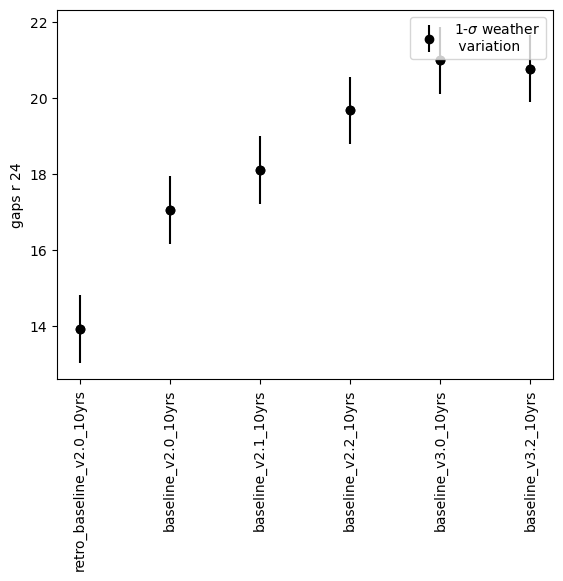

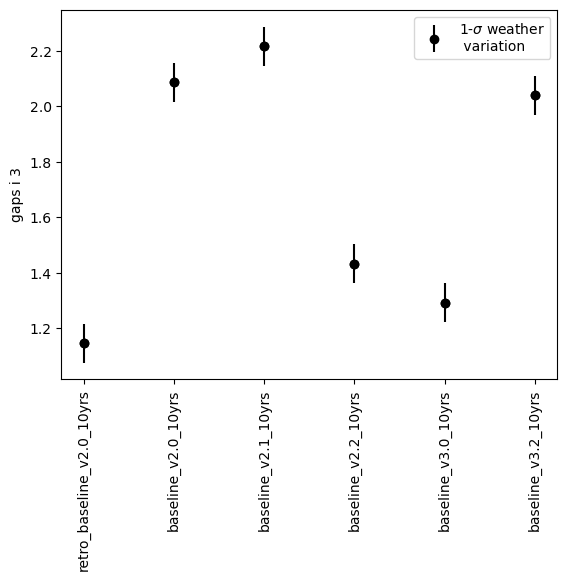

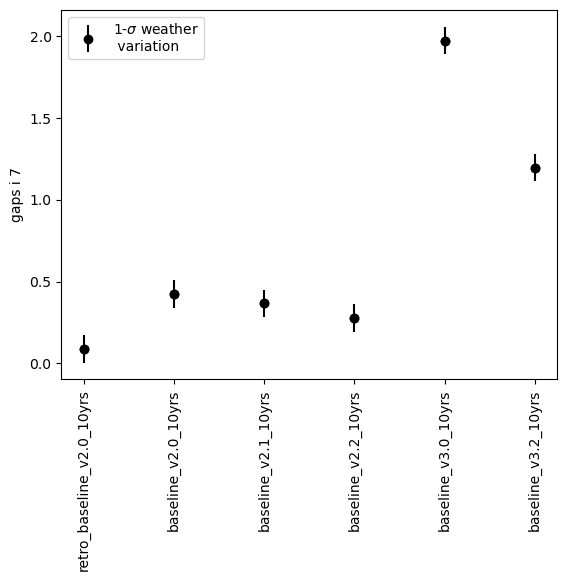

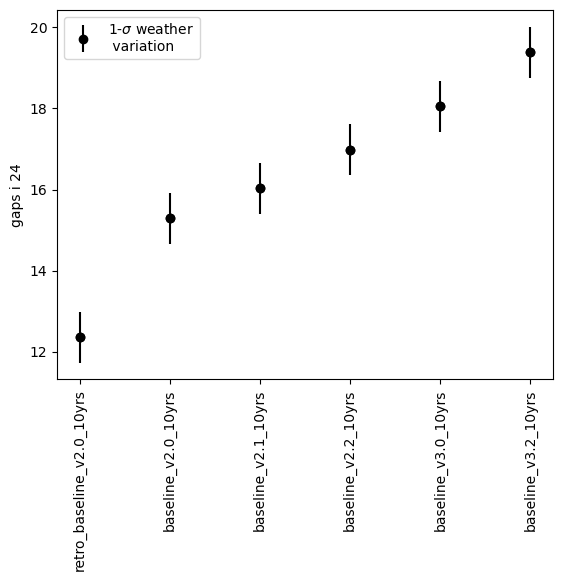

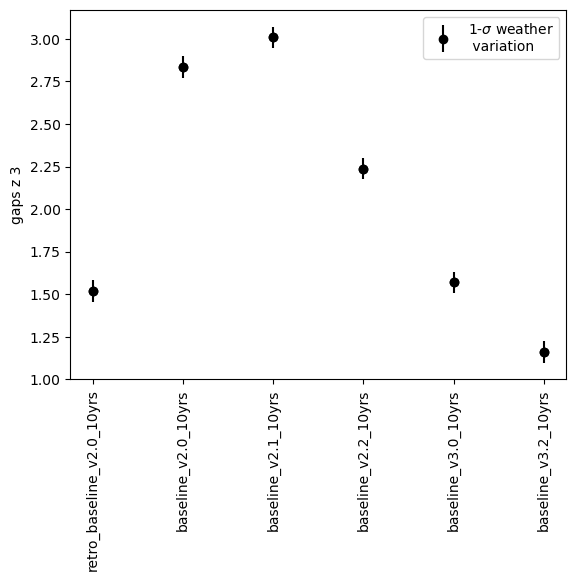

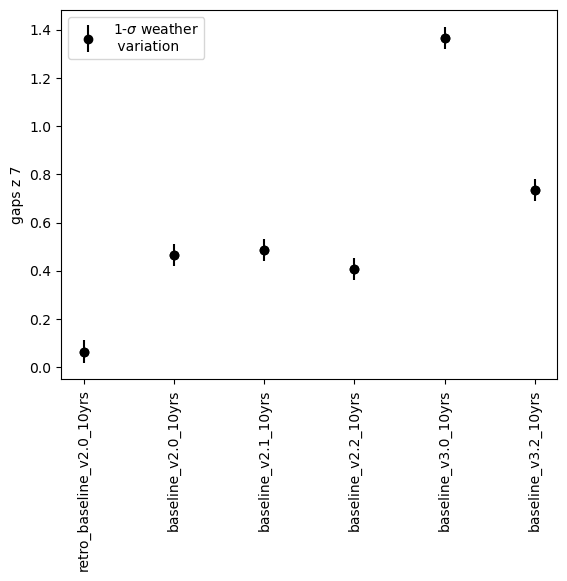

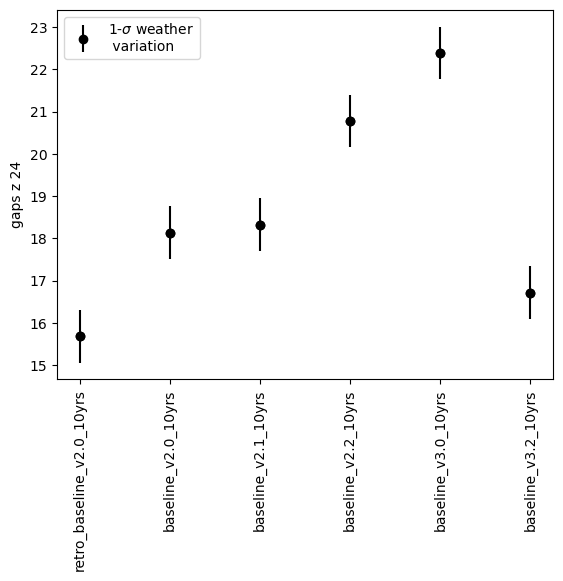

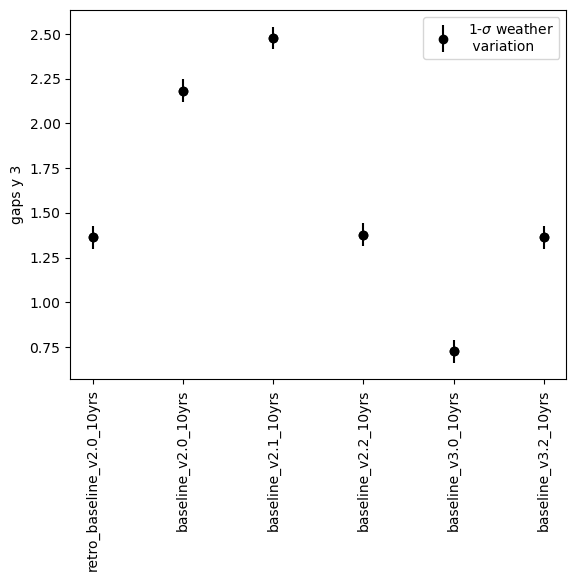

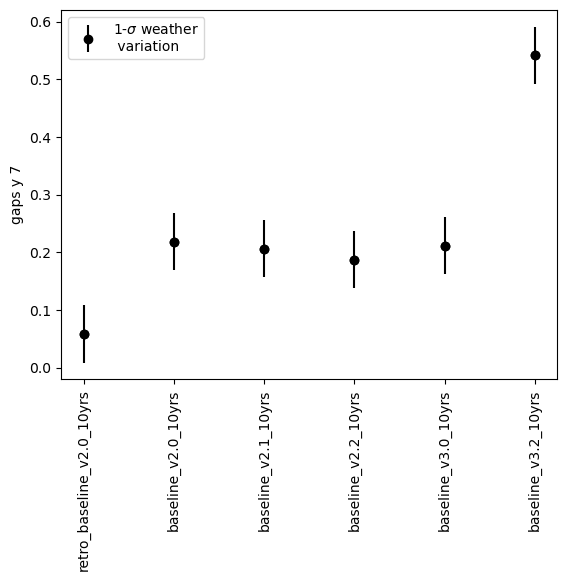

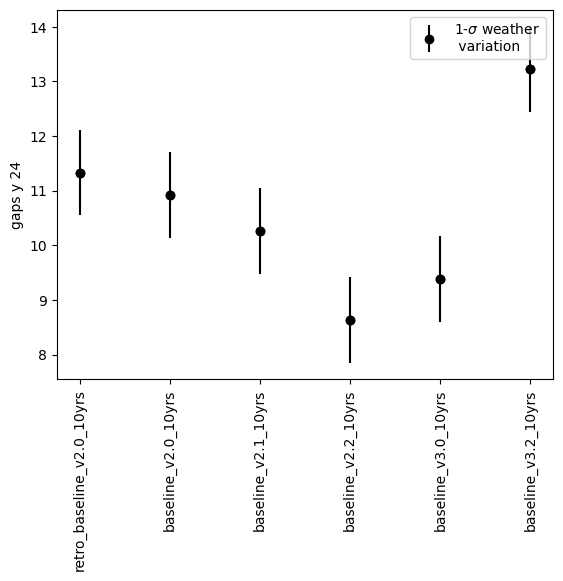

In [22]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs']

sub_gaps = gaps_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/3623228712.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


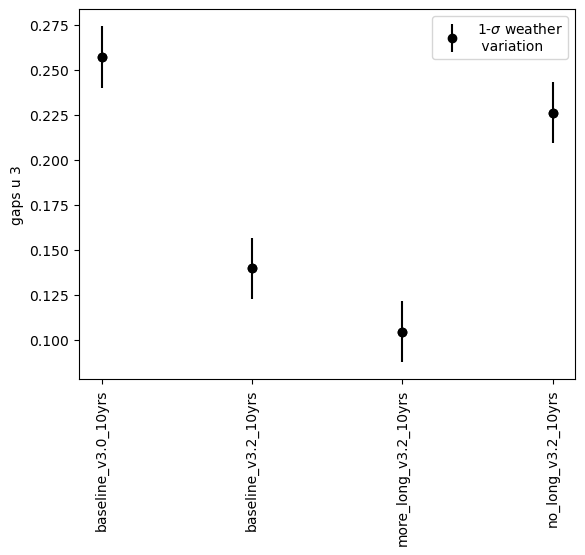

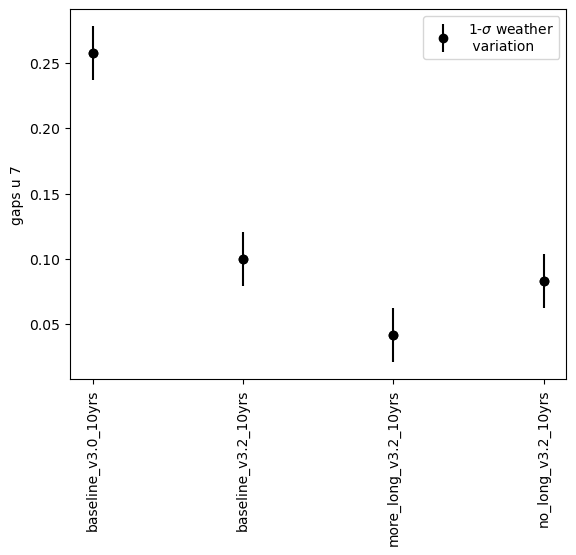

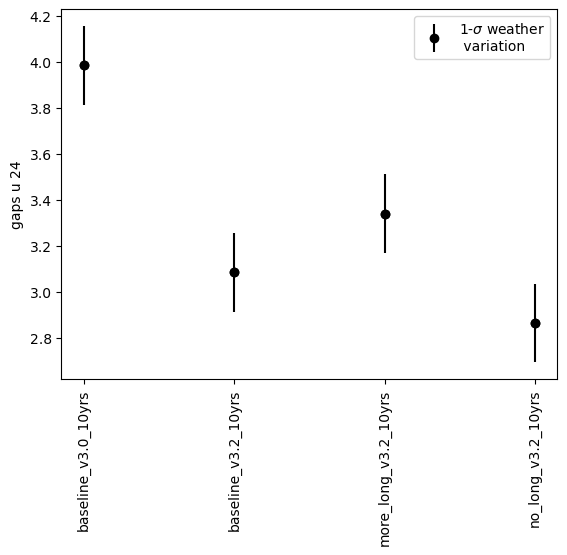

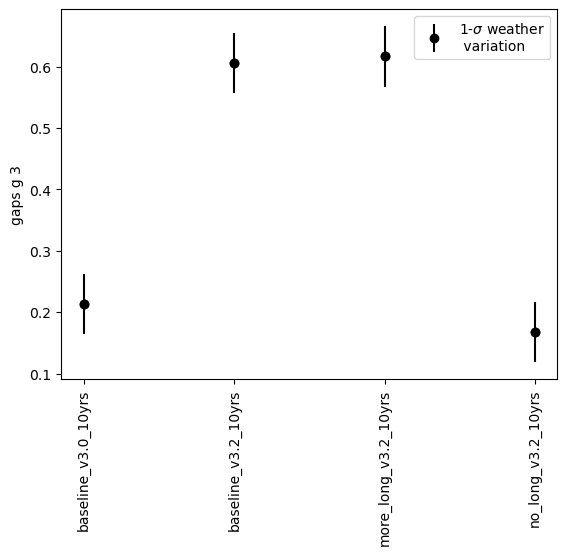

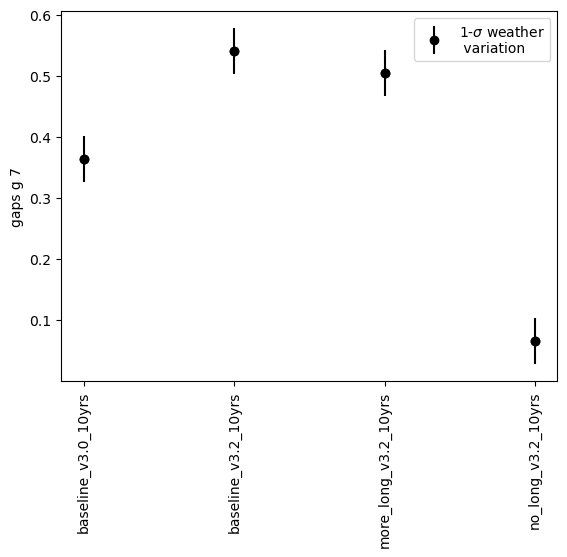

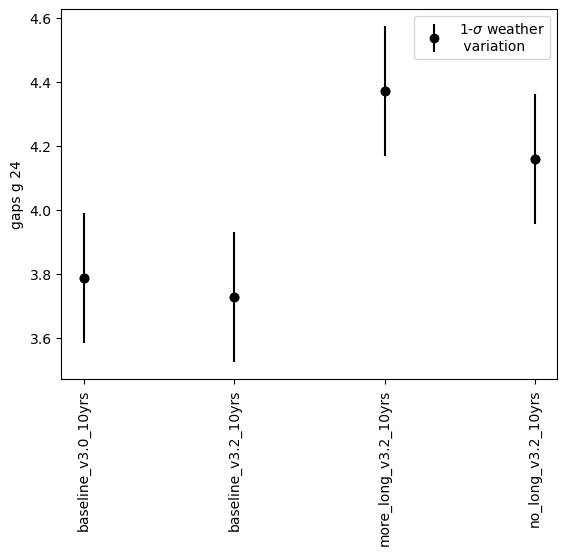

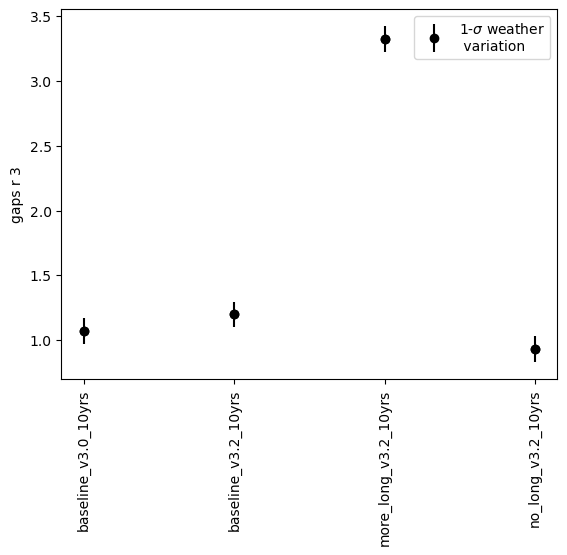

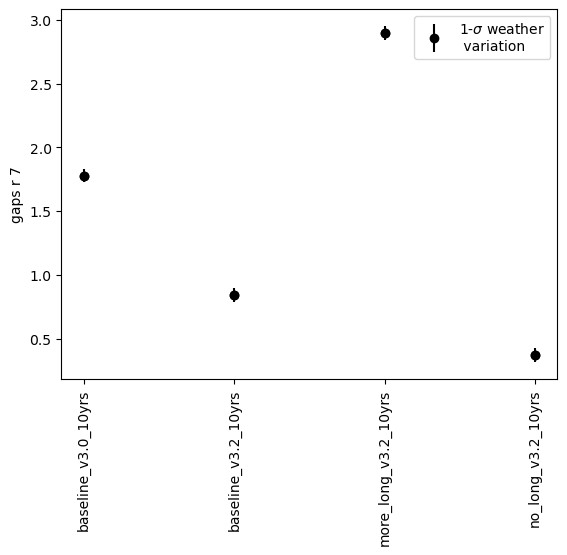

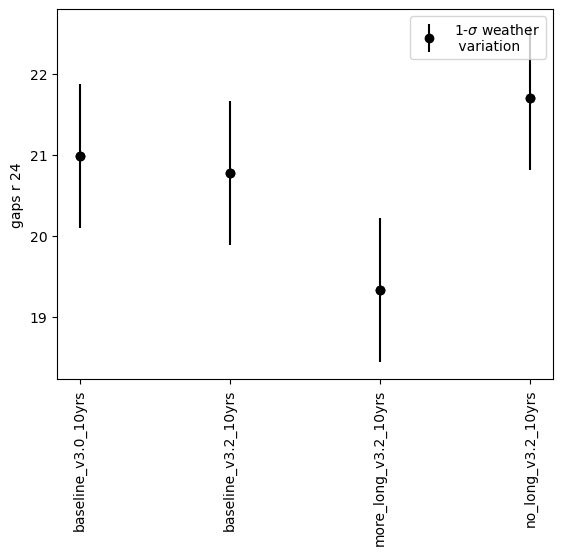

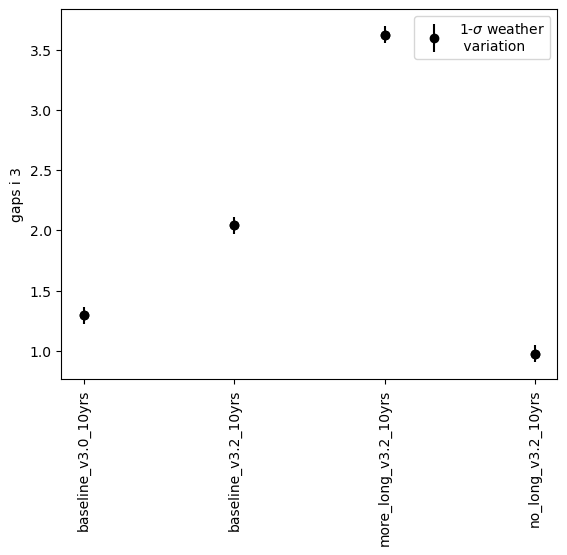

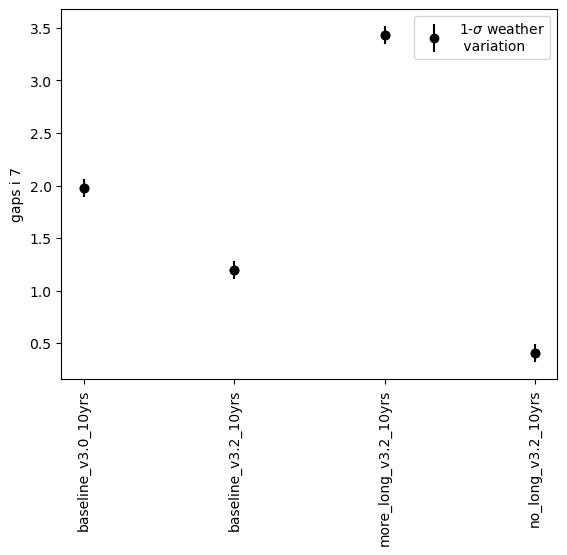

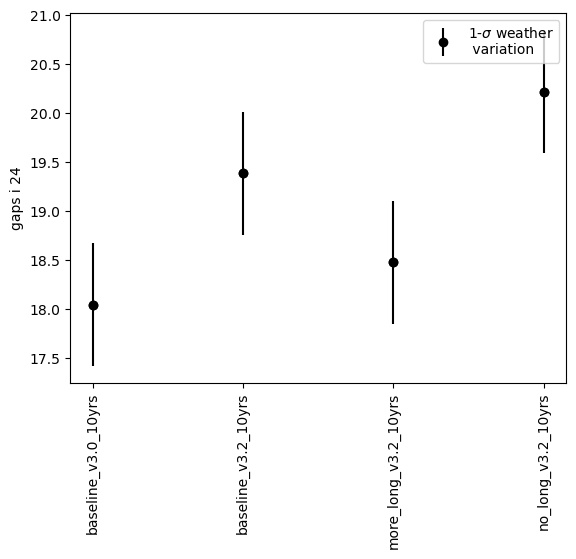

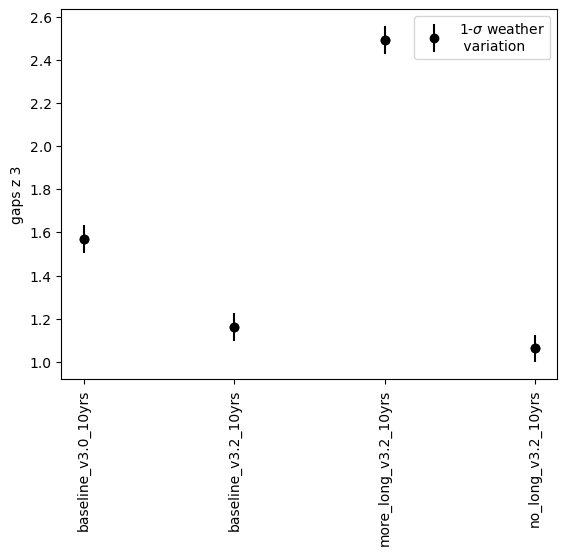

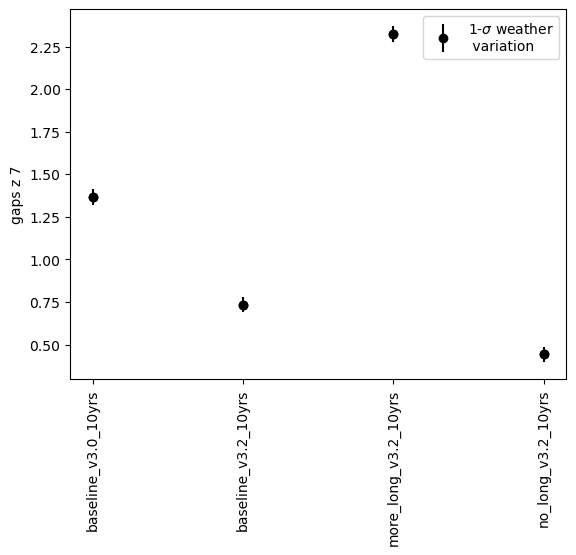

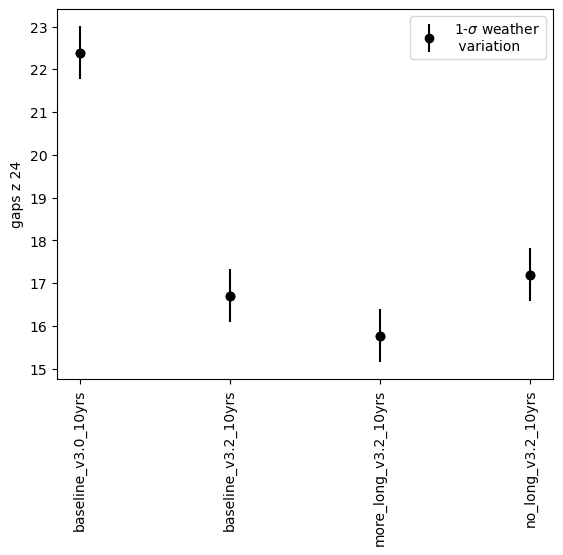

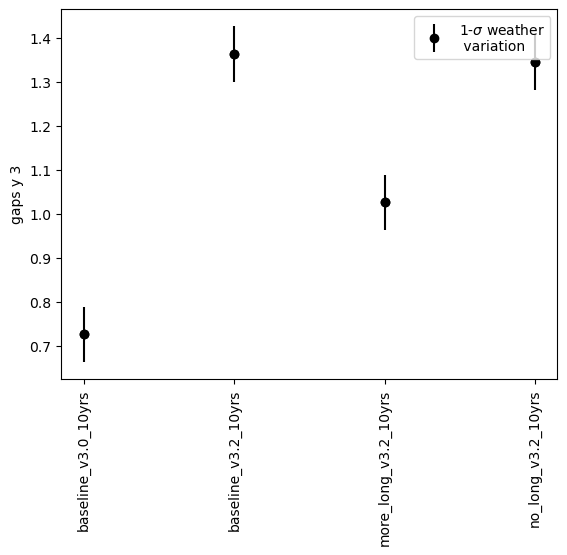

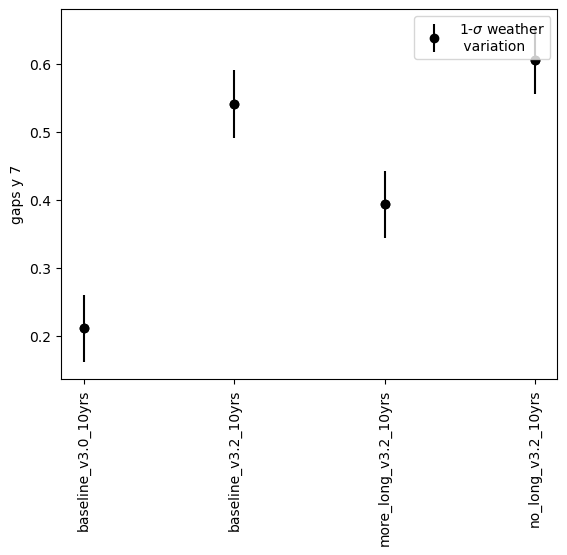

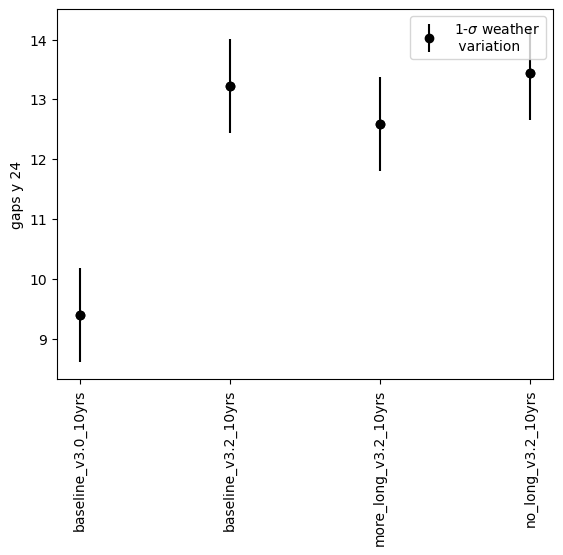

In [23]:
times = ['baseline_v3.0_10yrs',  'baseline_v3.2_10yrs'] + [run for run in data.index if '_long' in run]

sub_gaps = gaps_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/2400977859.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


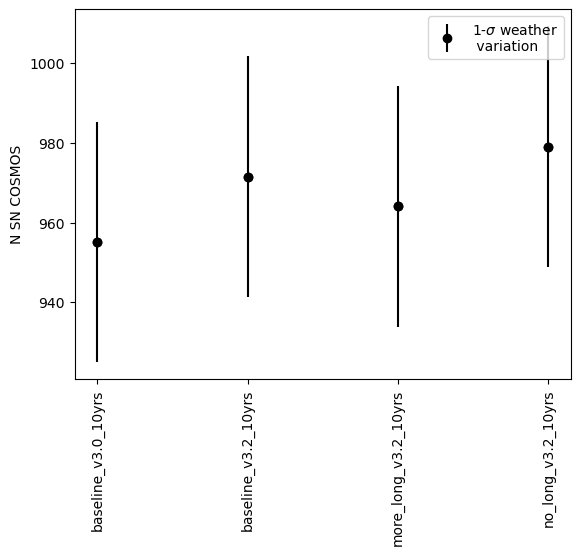

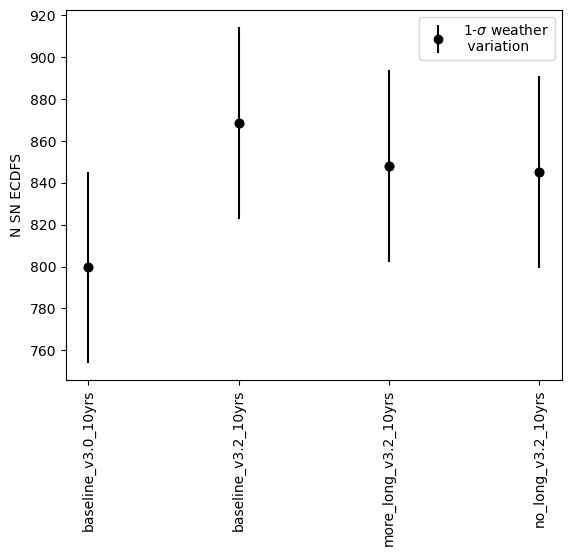

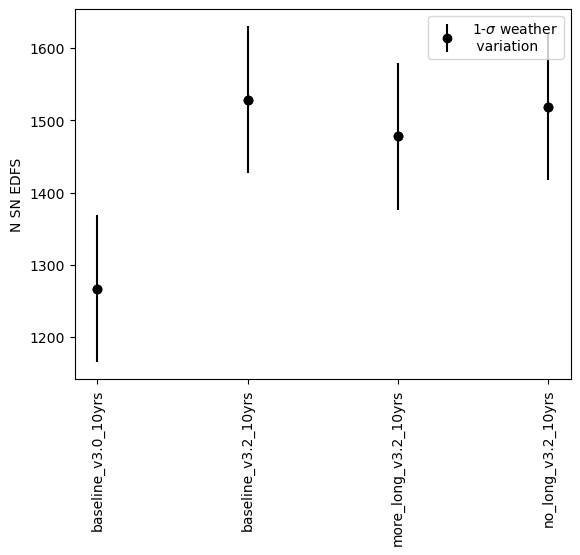

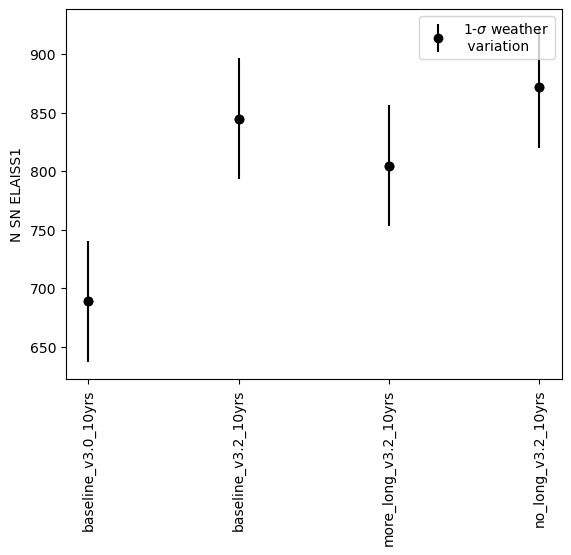

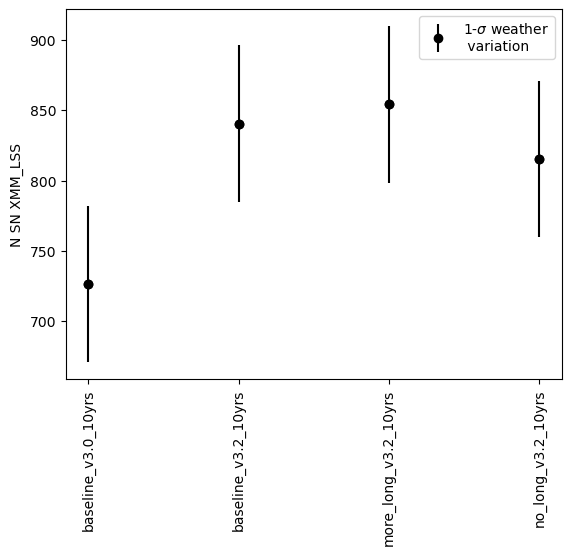

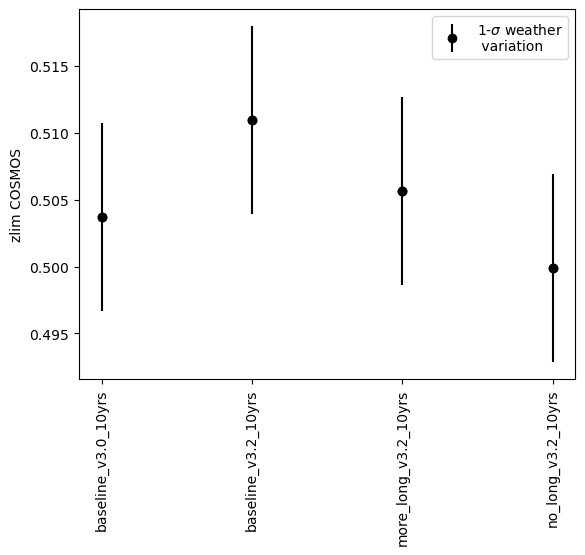

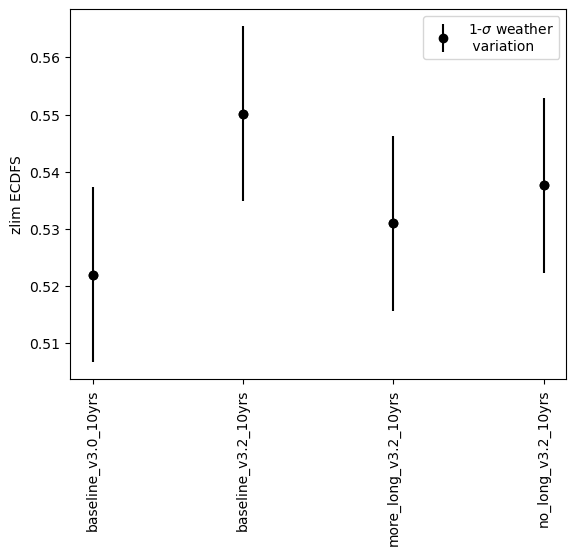

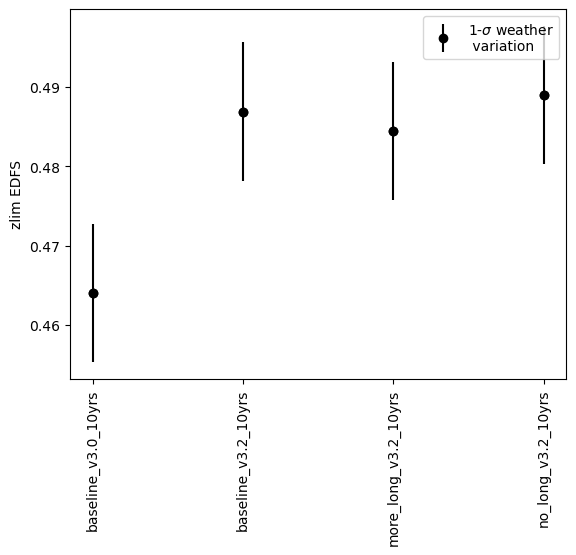

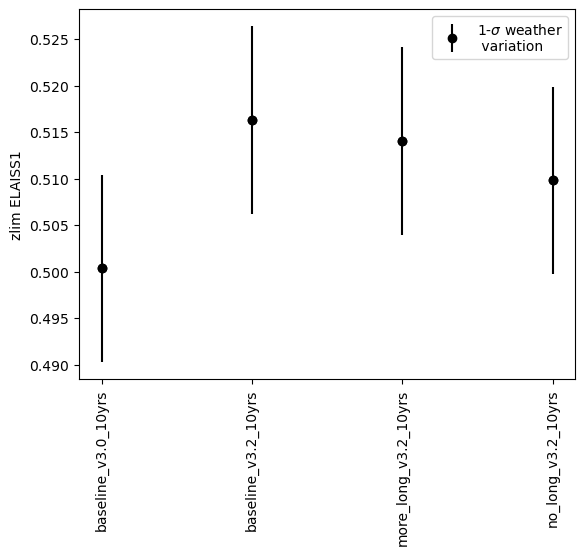

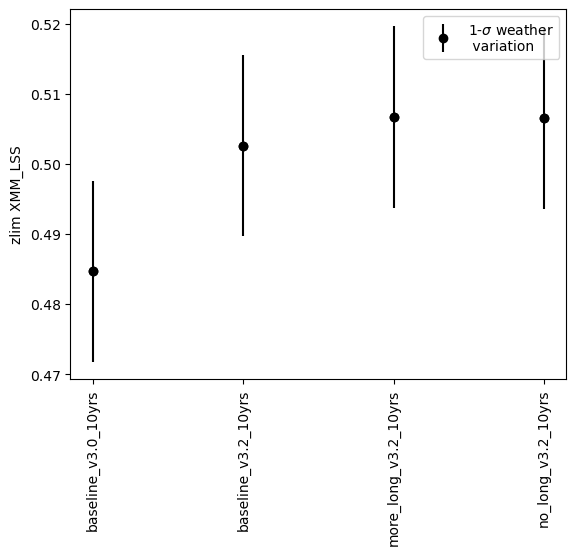

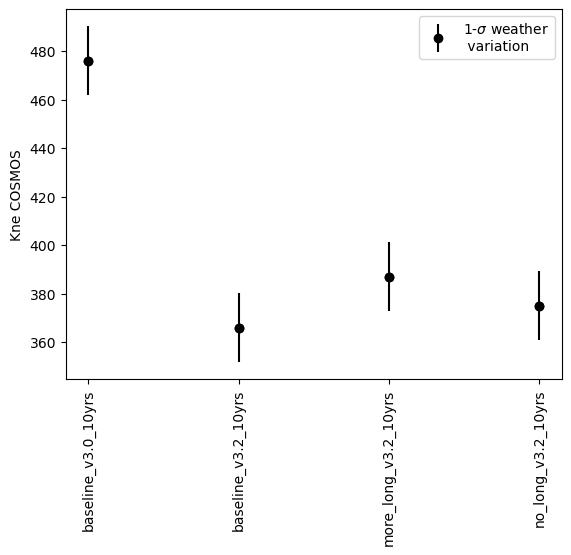

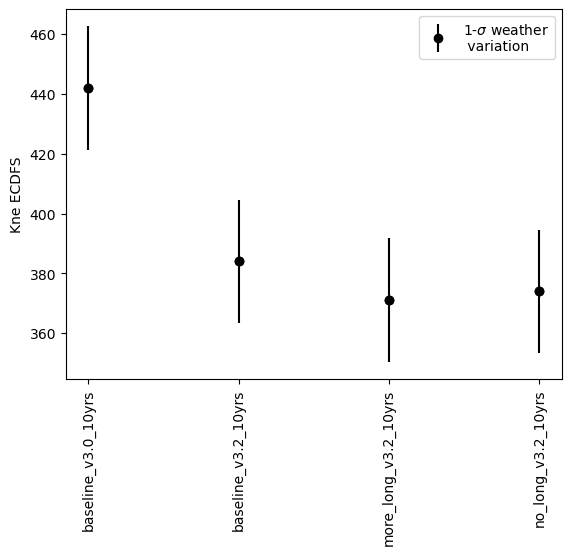

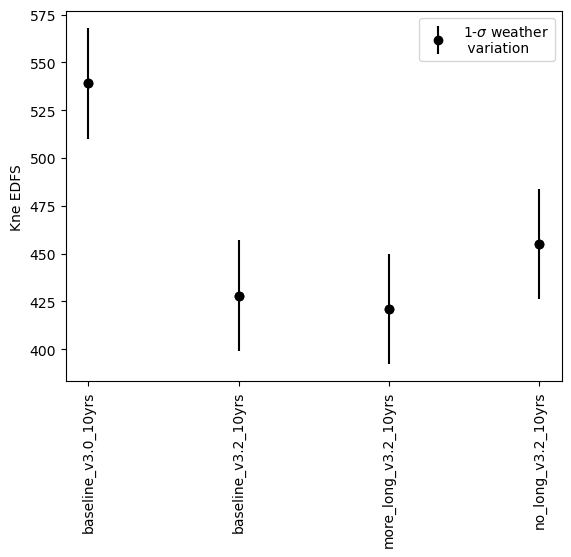

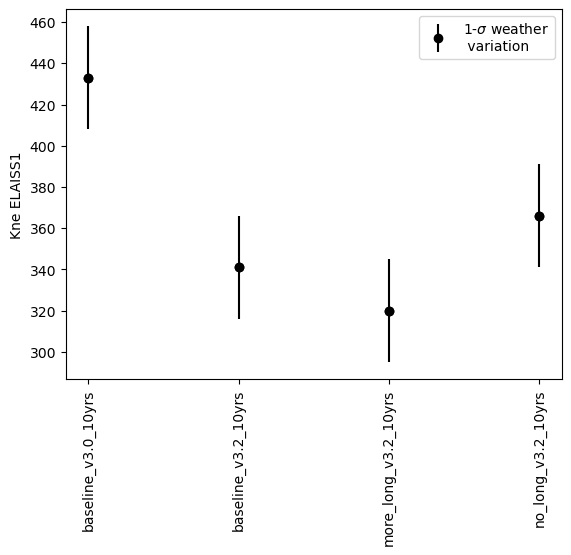

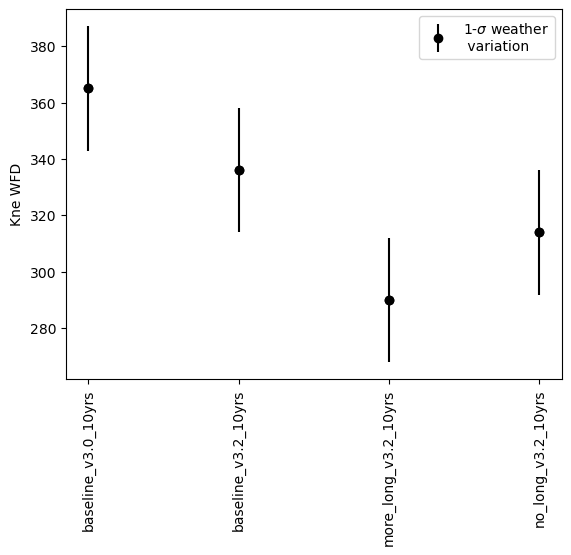

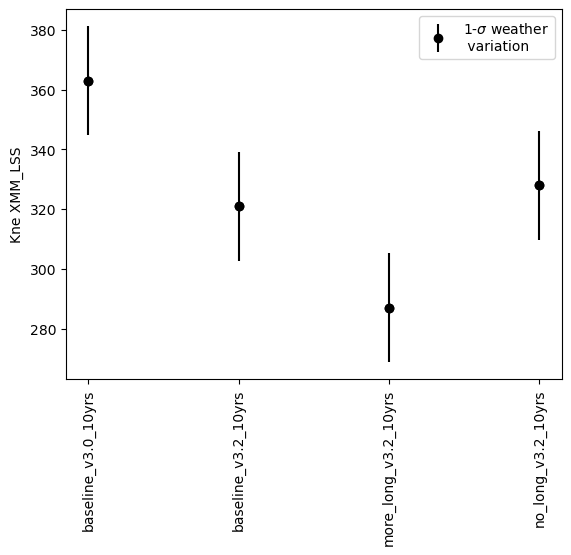

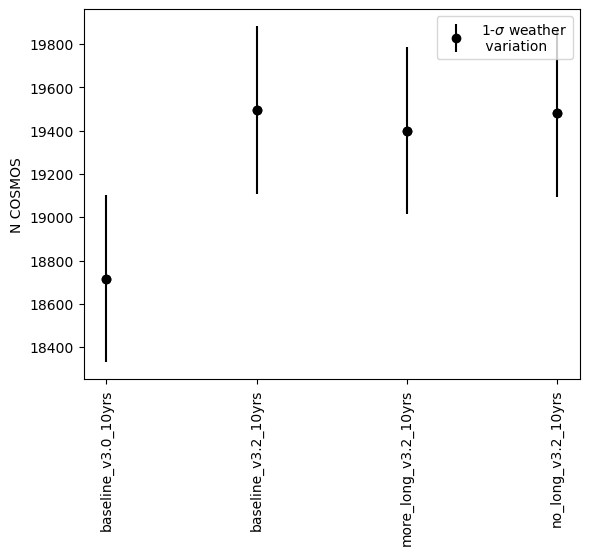

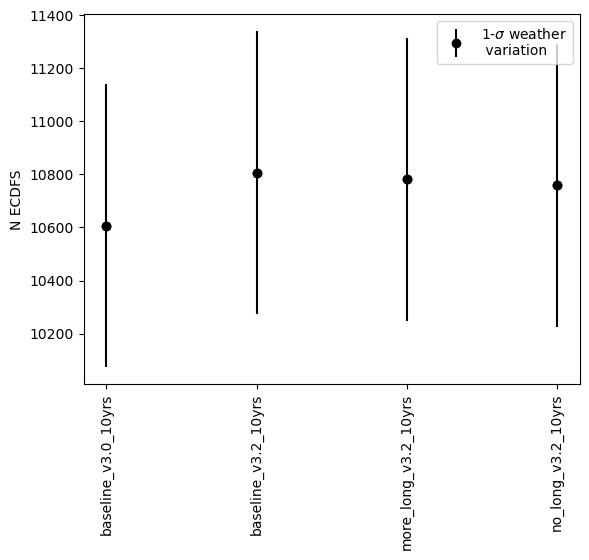

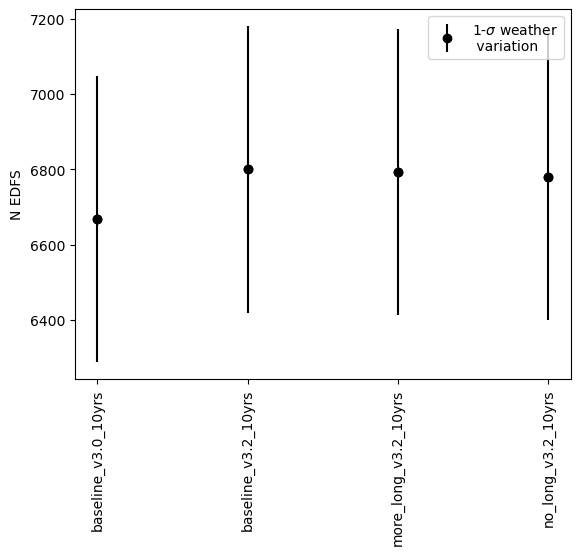

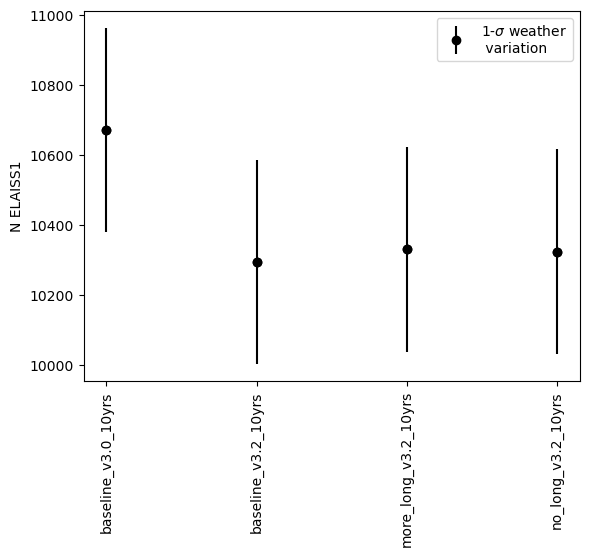

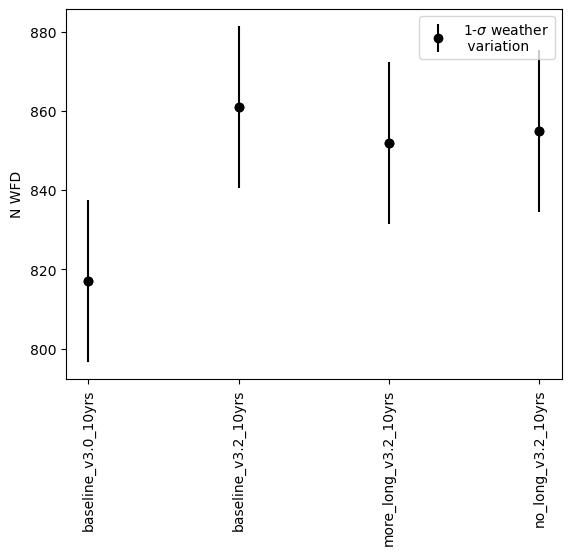

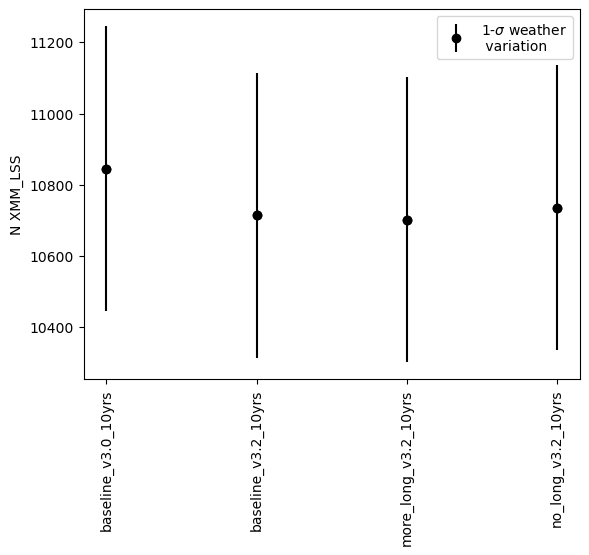

In [24]:
sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/1088104815.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


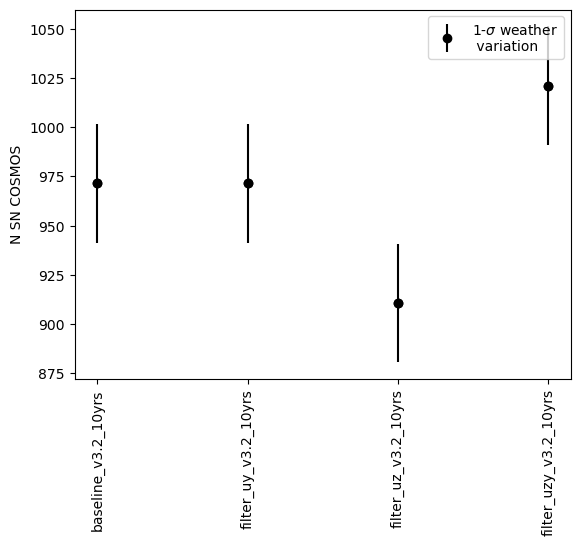

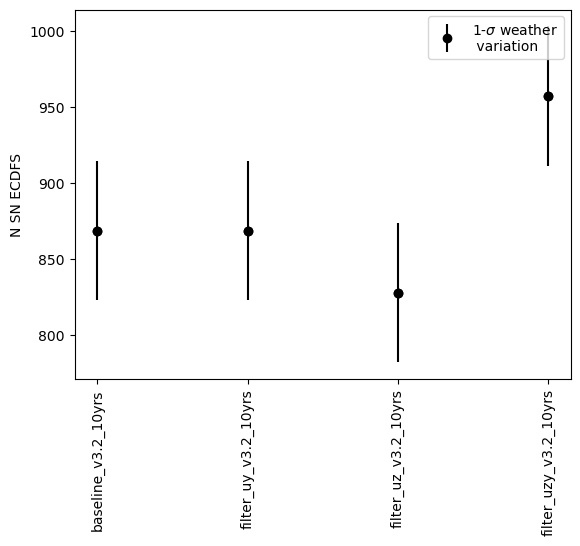

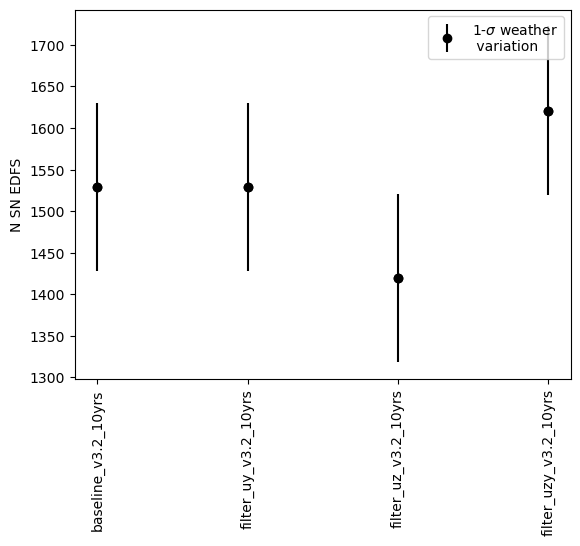

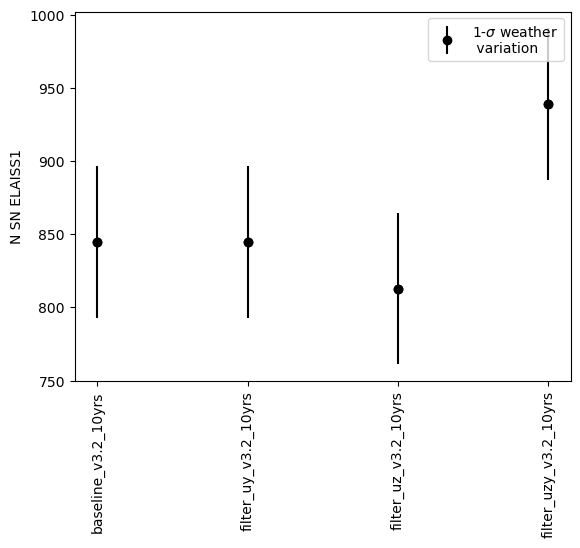

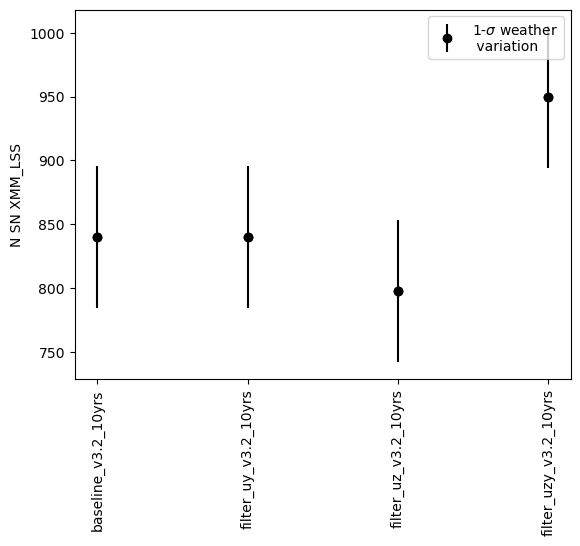

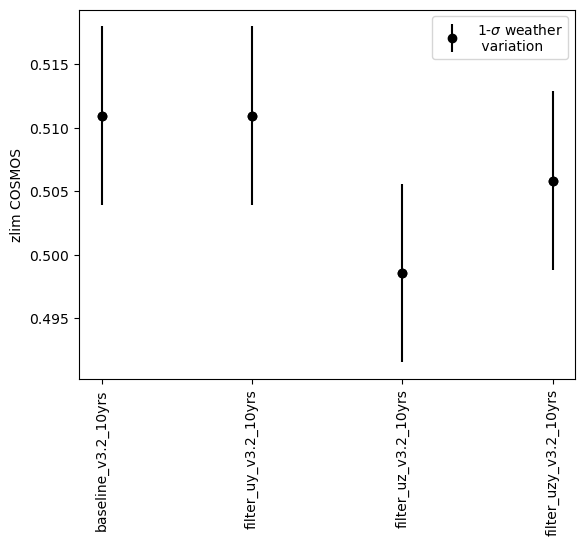

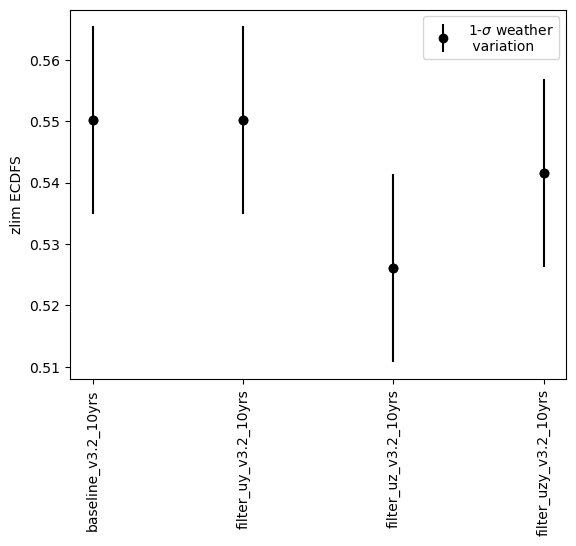

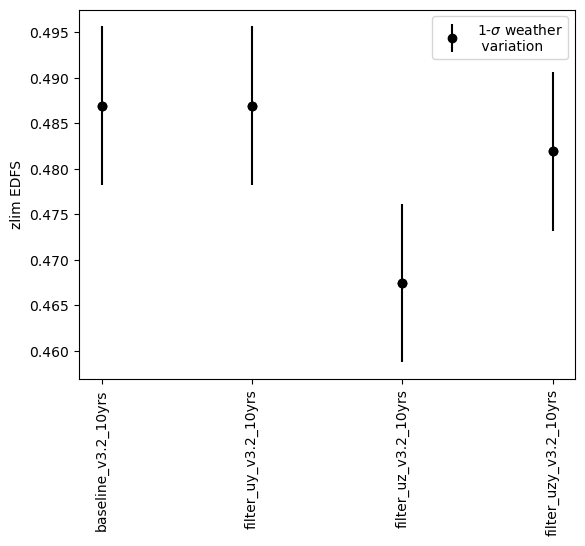

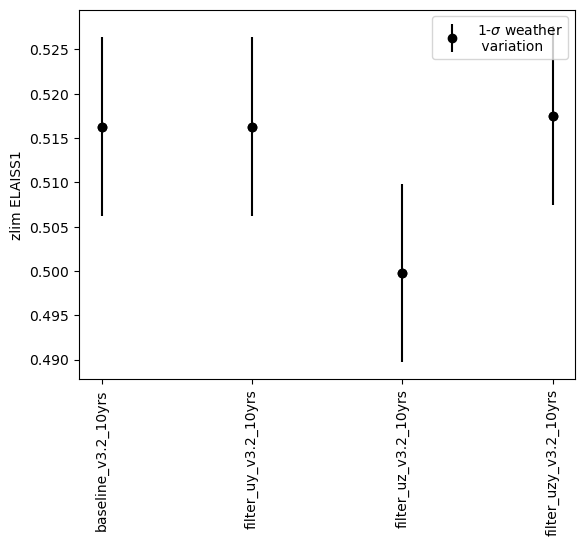

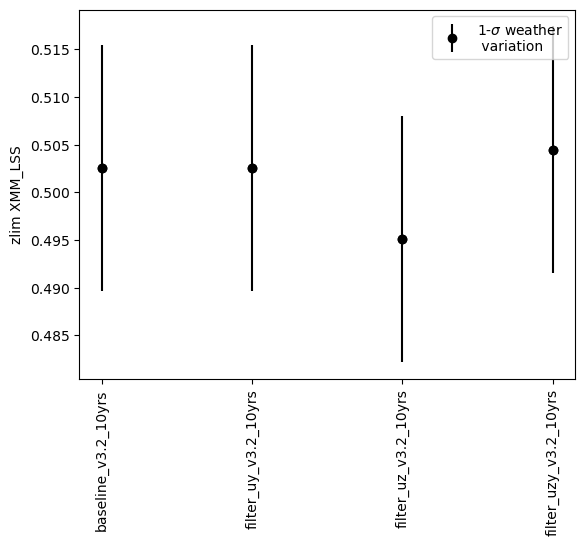

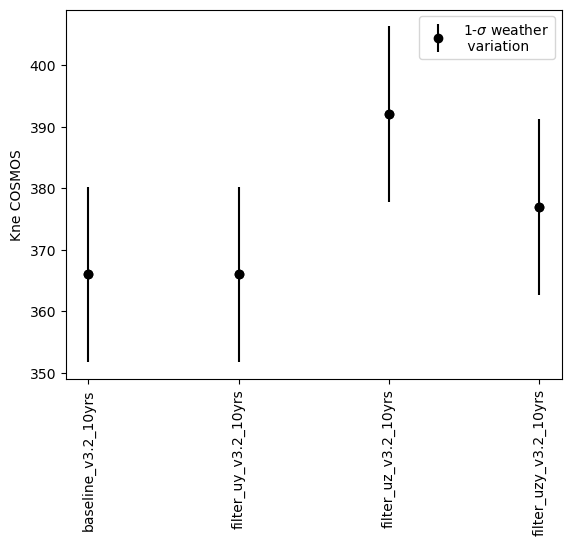

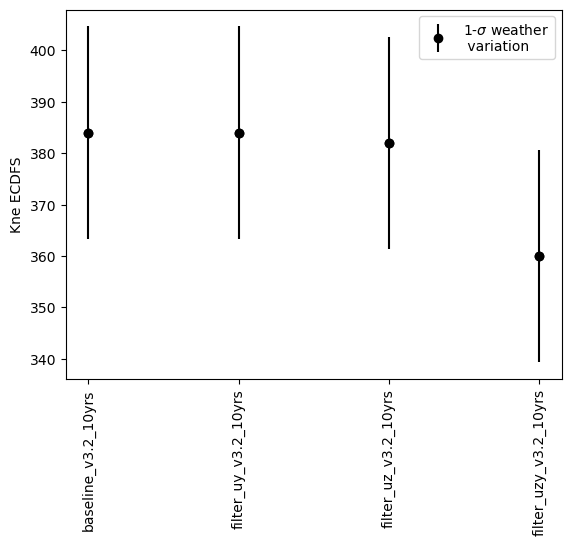

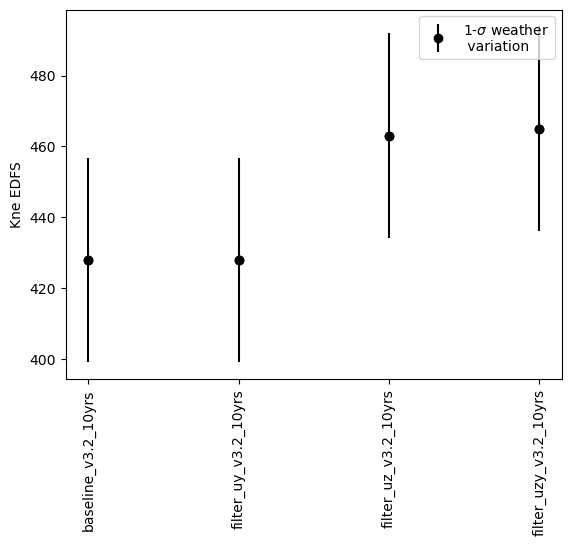

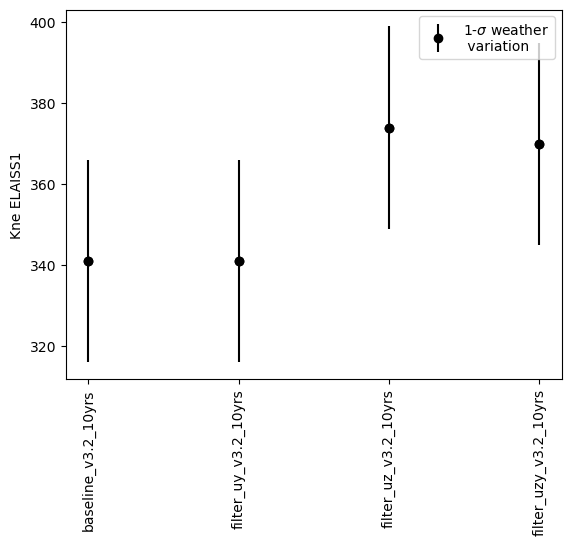

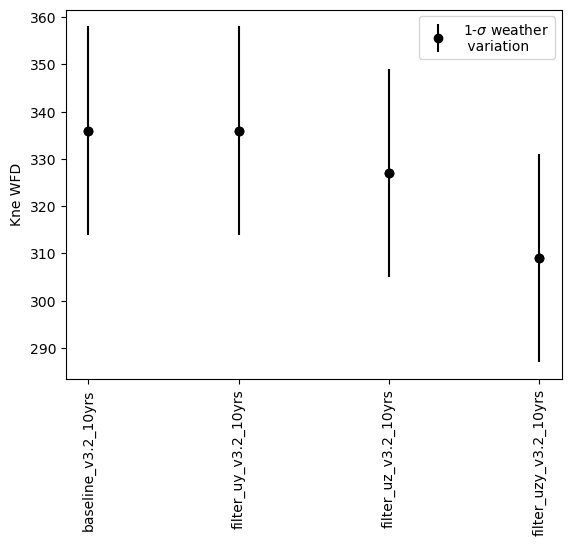

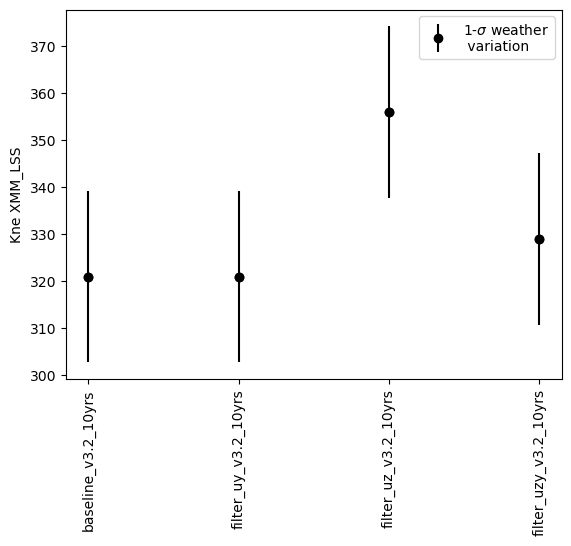

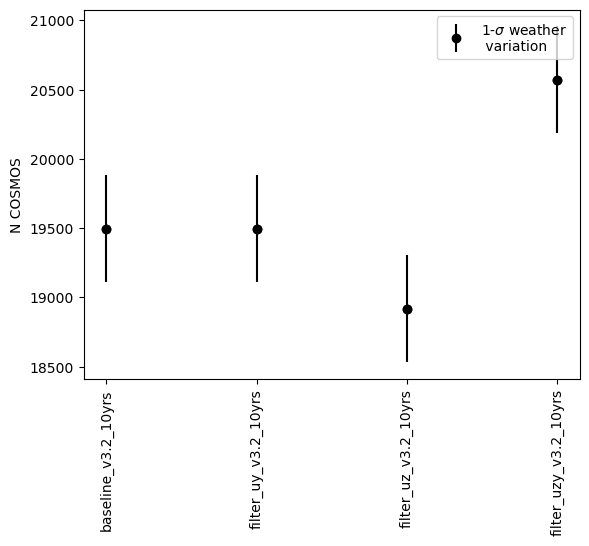

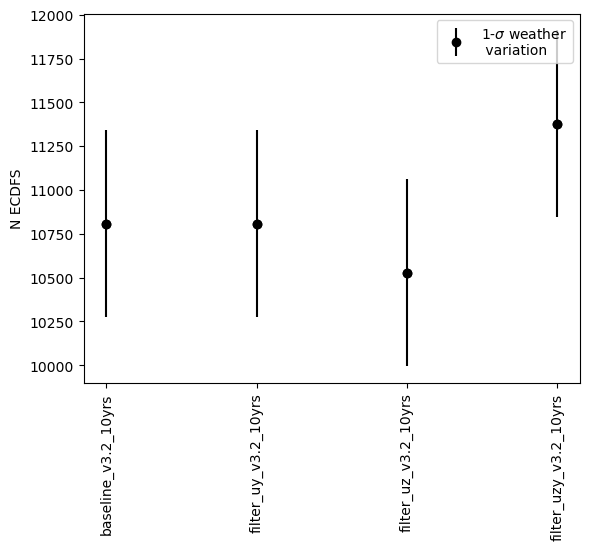

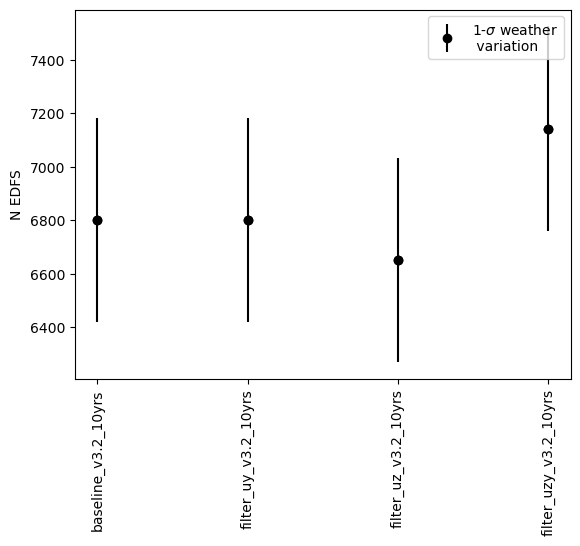

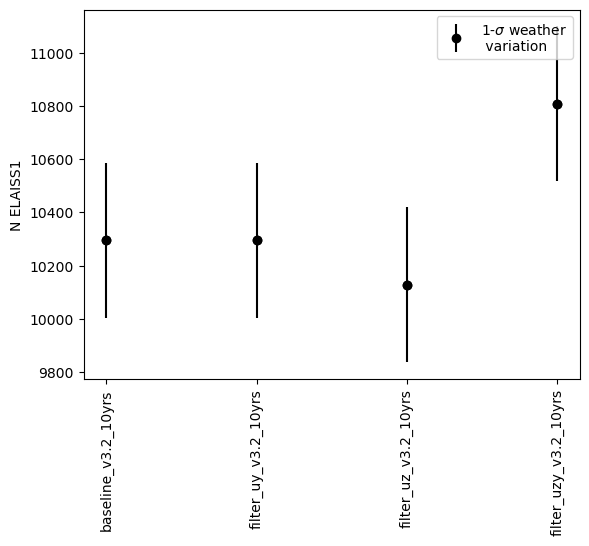

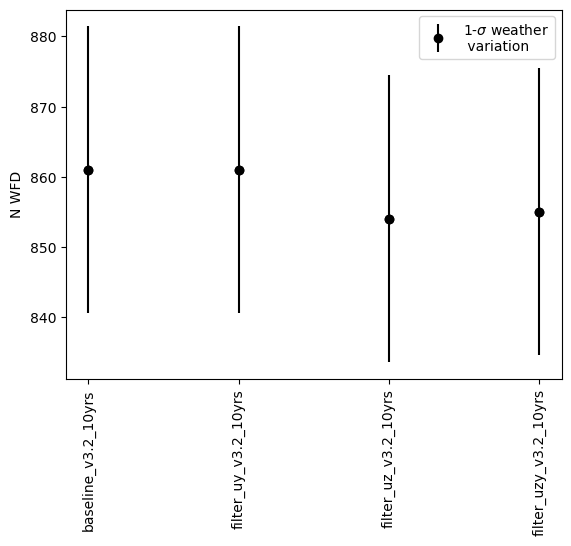

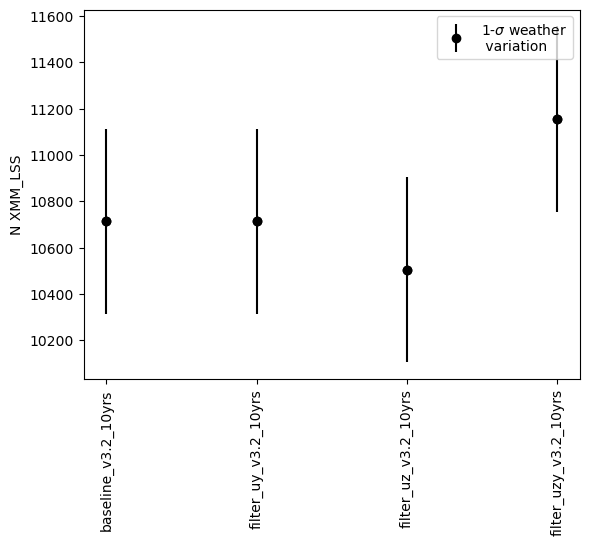

In [25]:

times = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'filter' in run]

sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_3601/2878332686.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


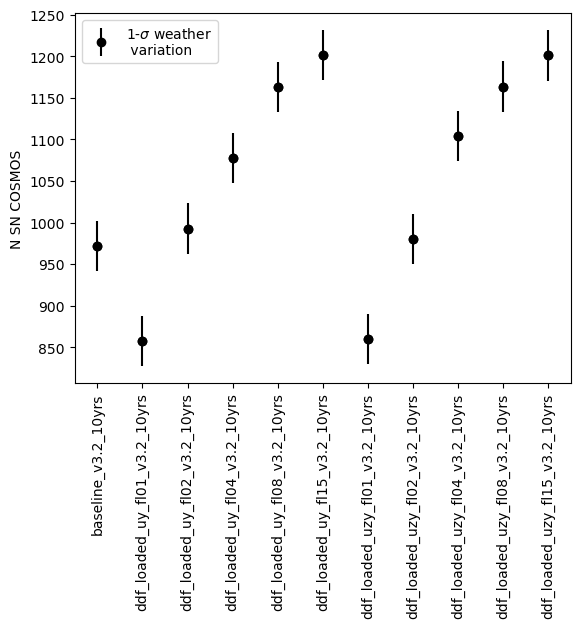

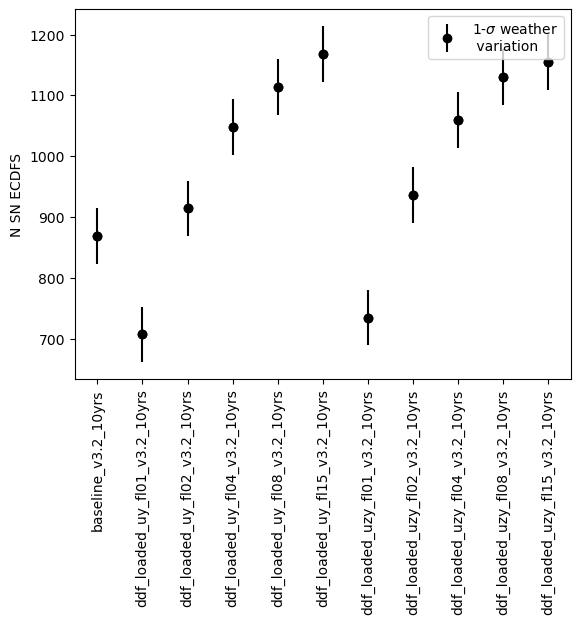

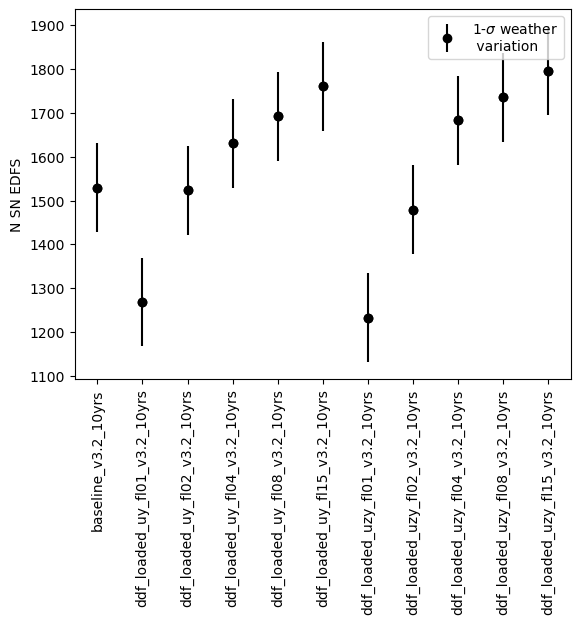

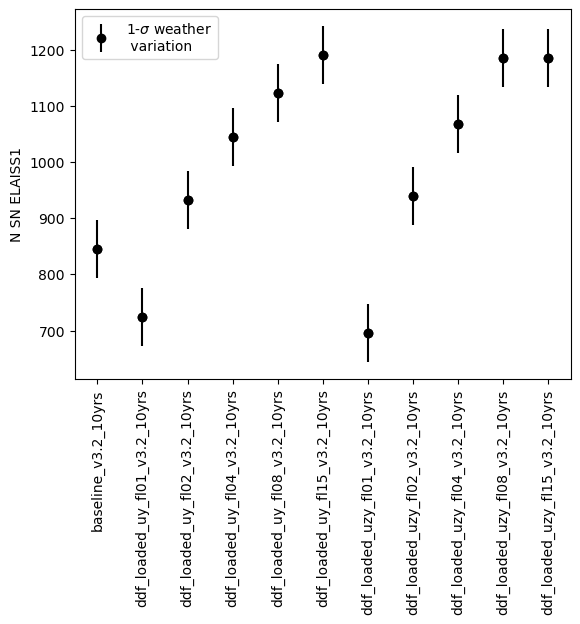

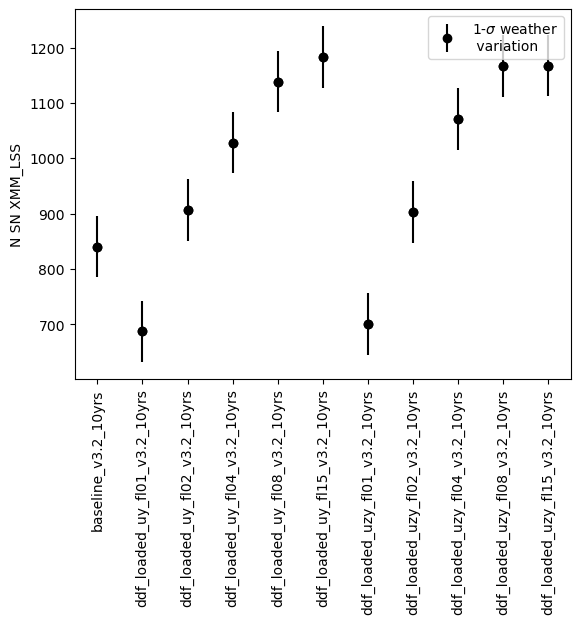

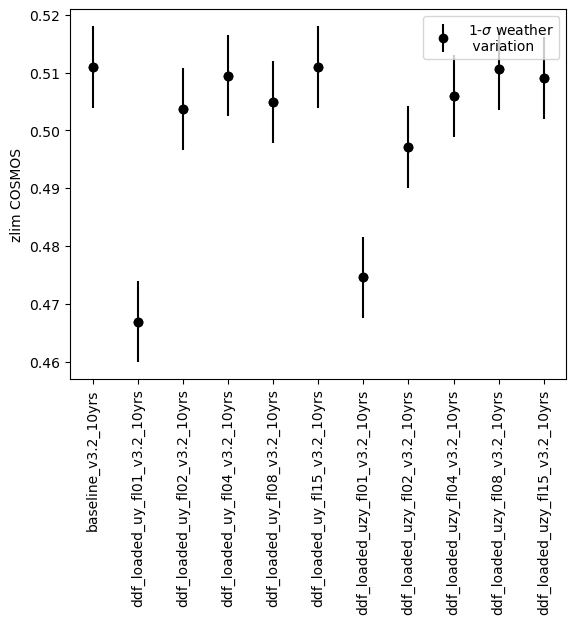

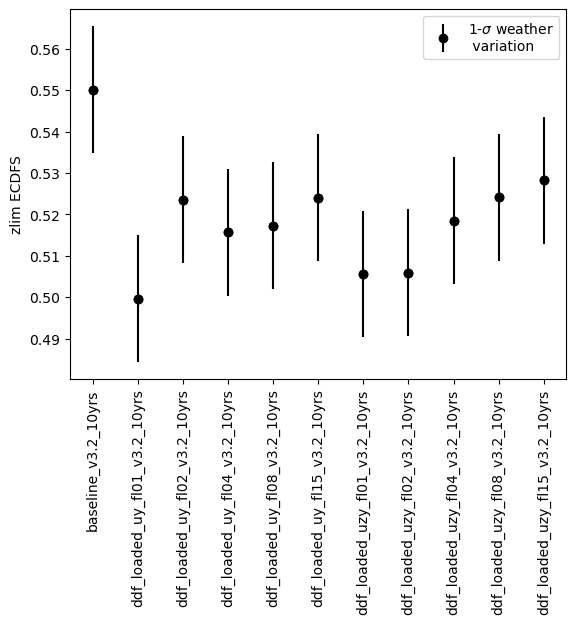

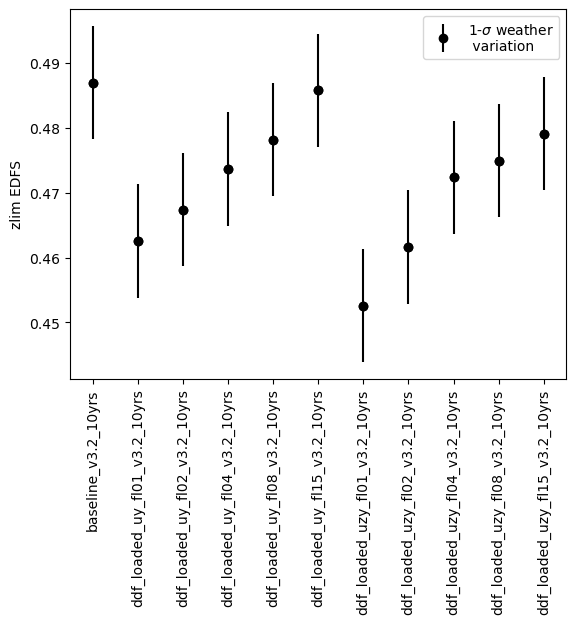

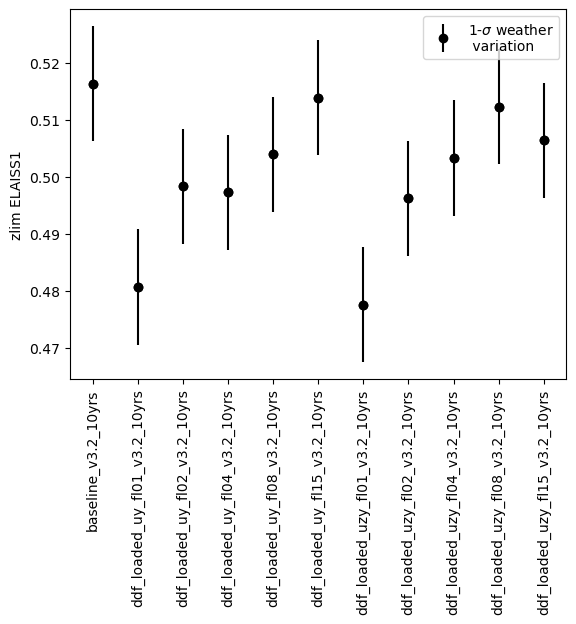

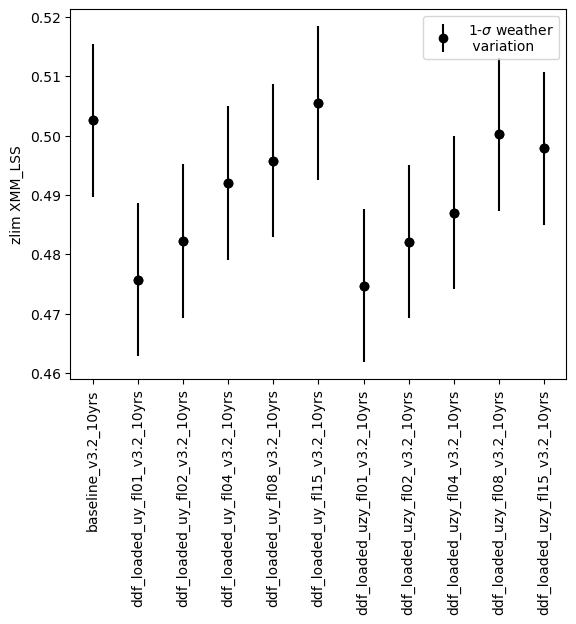

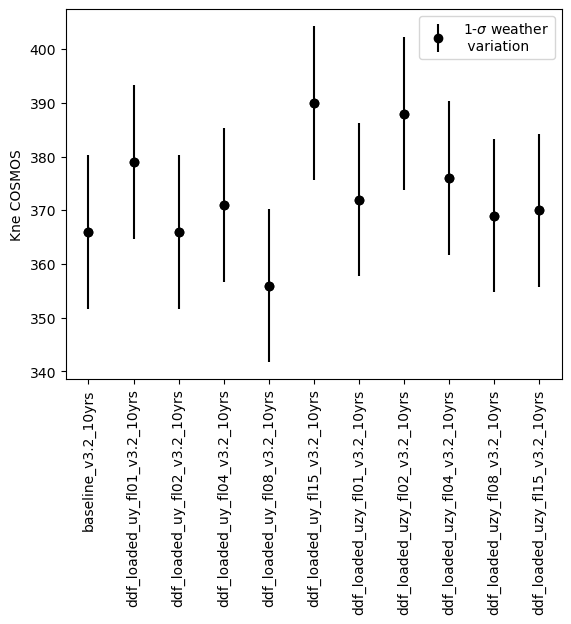

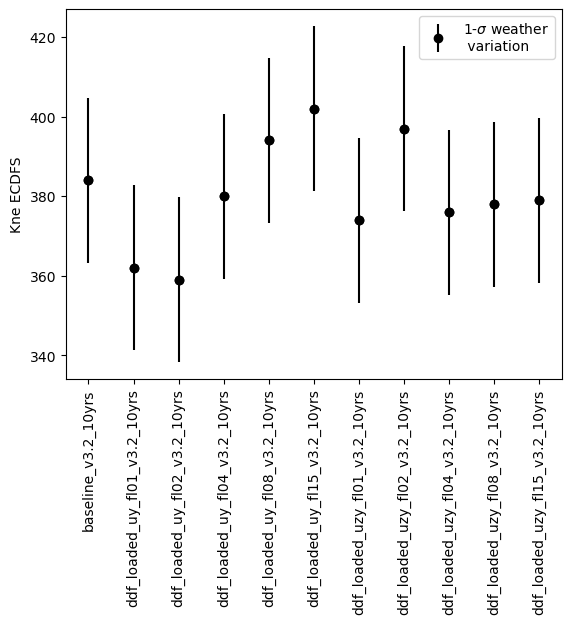

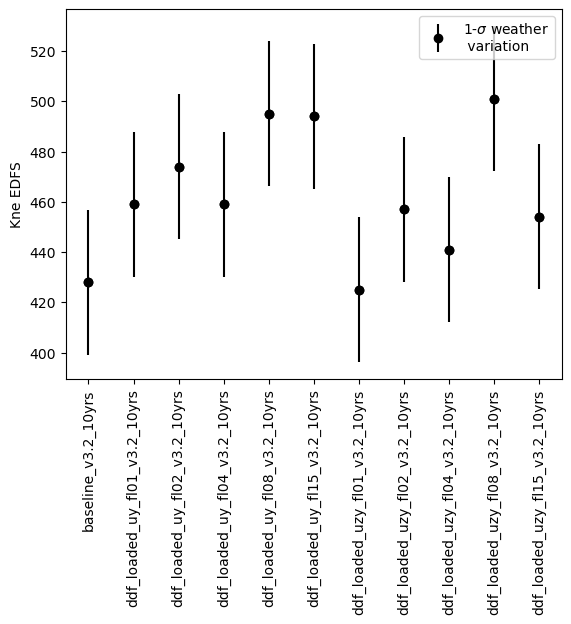

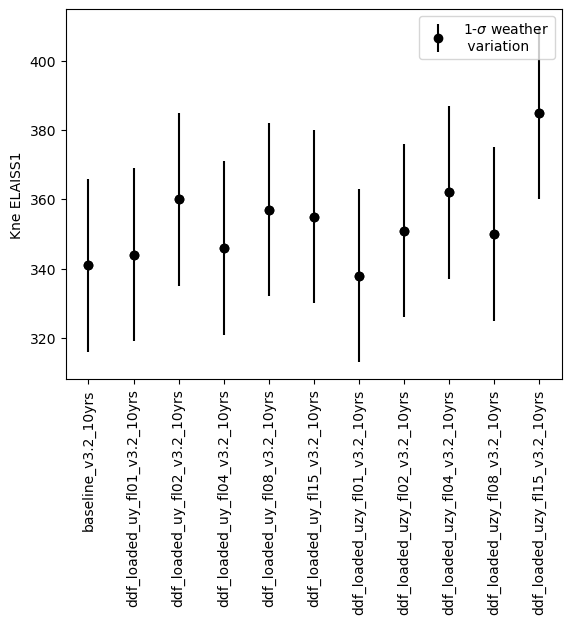

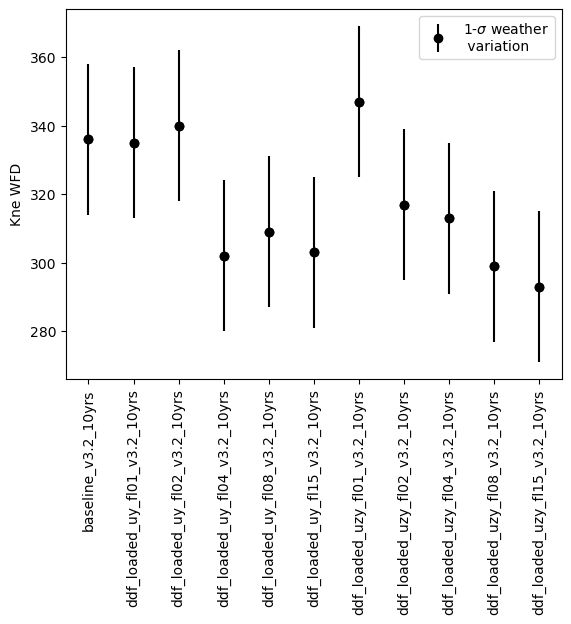

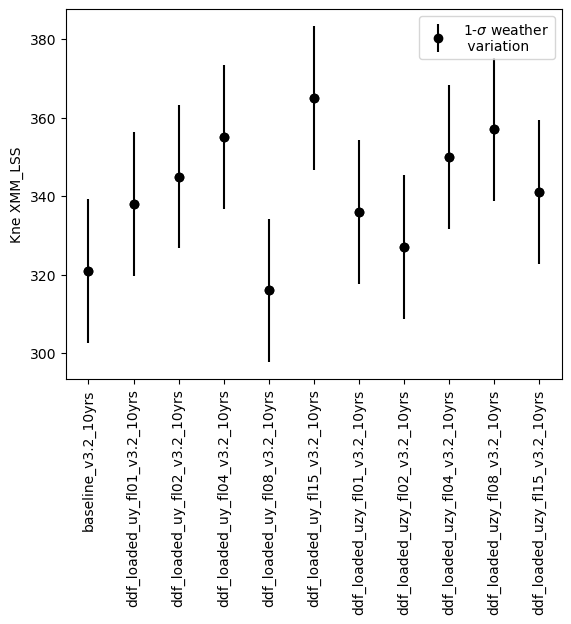

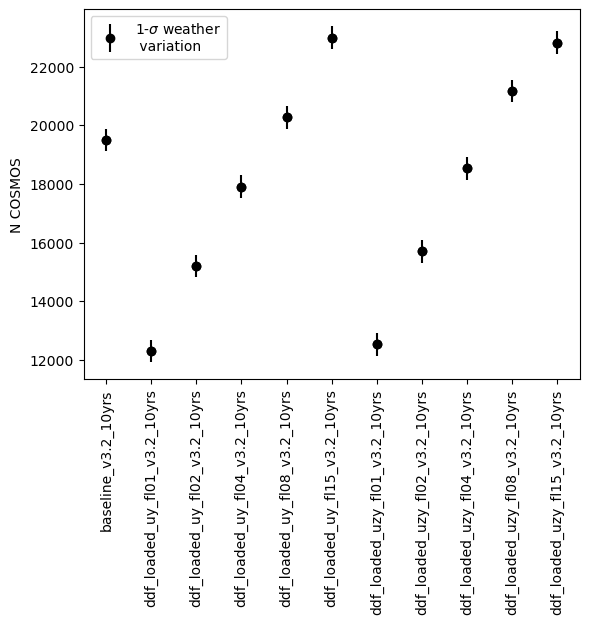

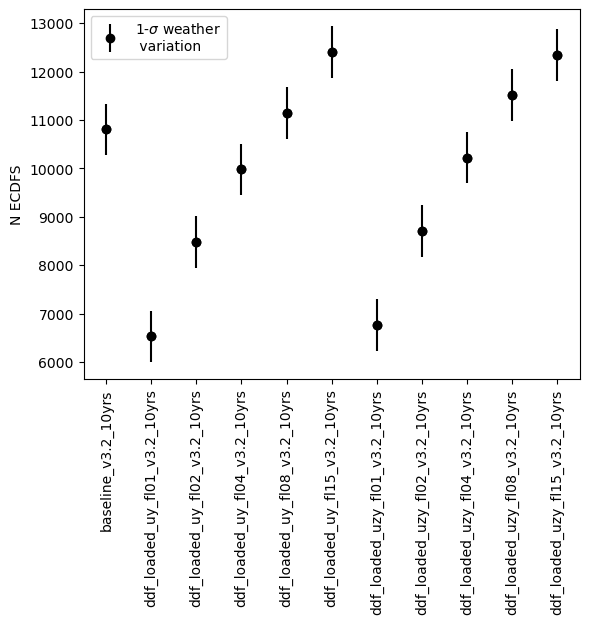

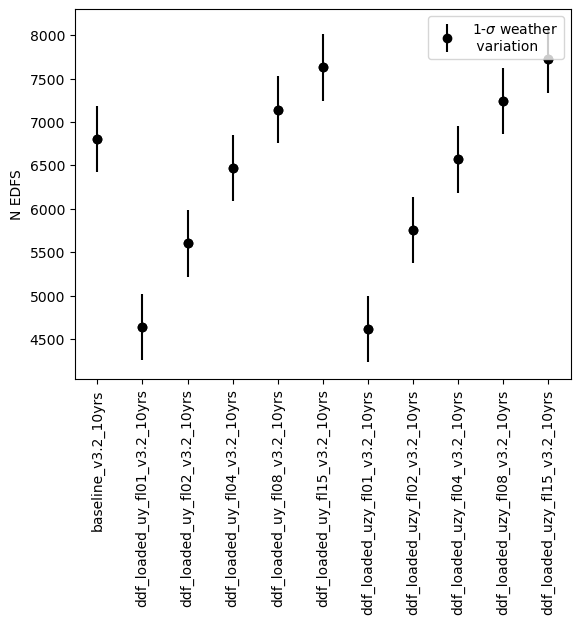

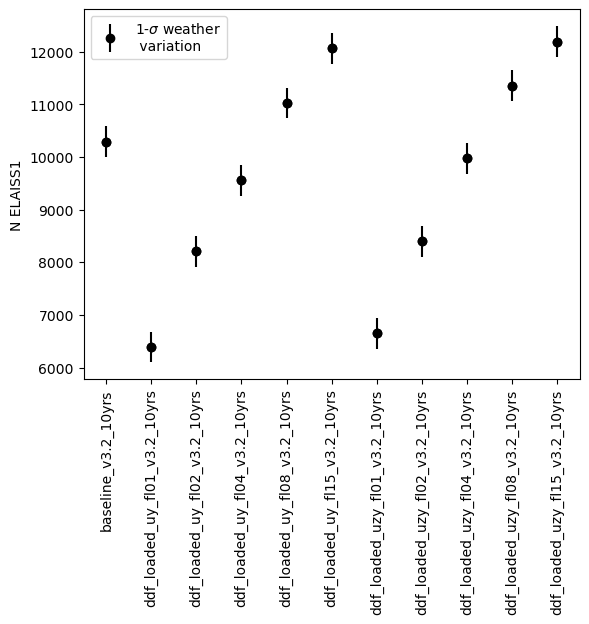

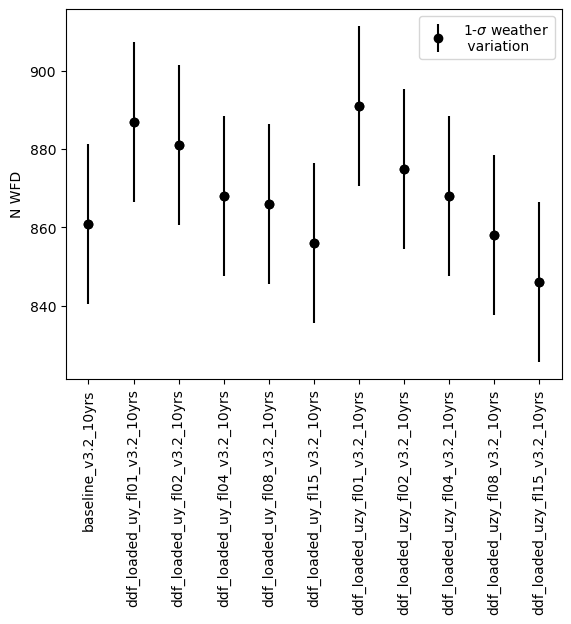

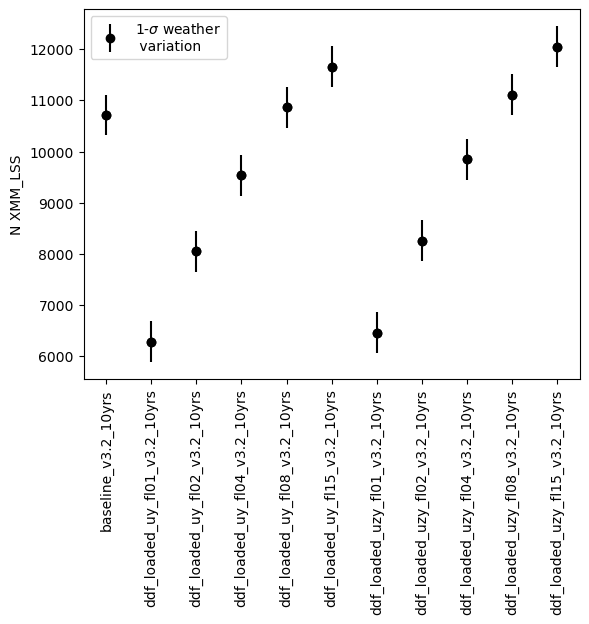

In [26]:
times = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run]

sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

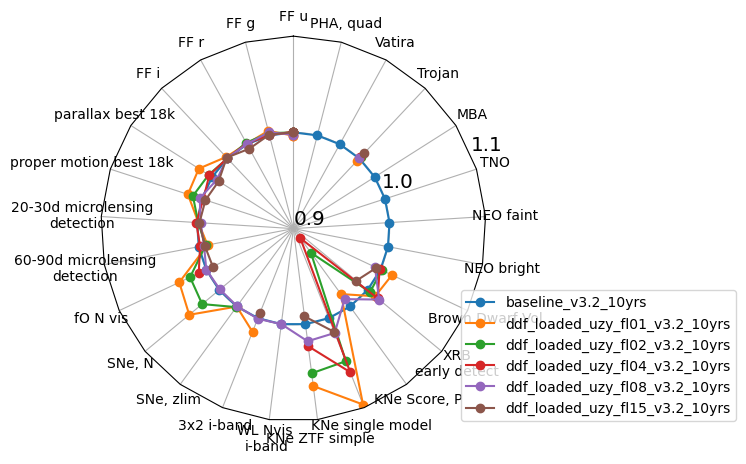

In [27]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run and 'uy' not in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

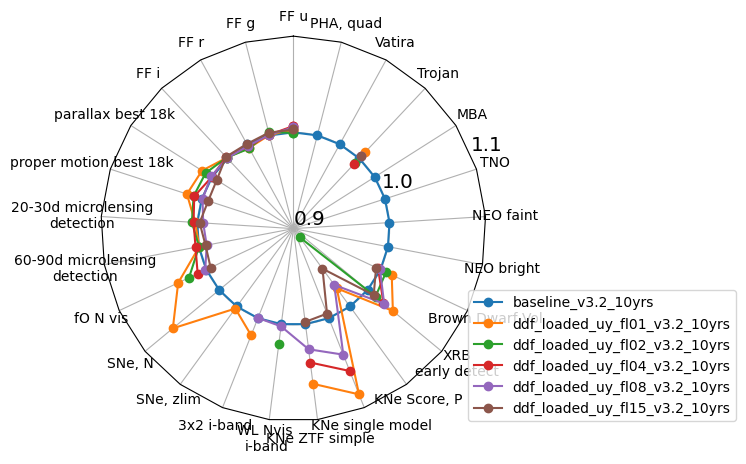

In [28]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run and 'uy' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))